In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.optimize import minimize
from sklearn.metrics import r2_score

# Управление рисками 2024. Домашнее задание №3.

*Дата выдачи: 10.04.2024*

*Дедлайн: 24.04.2024, 23:59*

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Привет!

В данном домашнем задании тебе предстоит построить кривые def rate и clo rate (подробные пункты перечислены ниже). Для выполнения тебе понадобится выборка с данными, которую использовали на семинаре (**data_vintages.csv**), x_score и PD (**data_scores.csv**). Не бойся выходить за рамки методов, предложенных в лекции. Главное - не забывай **аргументировать** свой выбор и давать **комментарии** своим действиям.

Удачи!

#### Как будет оцениваться ваша работа:
За это ДЗ ты можешь получить максимум **10 баллов**. Все пункты весят по-разному, баллы указаны рядом с пунктами. Баллы могут сниматься в случае неполного выполнения задания или отсутствия аргументации.


#### Задачи:

1) Построить кривые DEF rate (5 баллов)
    - Выбрать переменную для разбивки по бакетам (0.5 балла)
    - Провести анализ поколений (0.5 балла)
    - Построить винтажи DEF rate (0.5 балла)
    - Провести анализ на особые точки (0.5 балла)
    - Провести анализ наличия внешних воздействий и при необходимости вычистить кривые (2 балла)
    - Построить среднее по винтажам для каждого бакета (0.5 балла)
    - Сгладить кривые (0.5 балла)
    
2) Построить кривые CLO rate (5 баллов)
    - Пункты, аналогчные DEF rate
    
**Пожалуйста, аргументируйте свои решения по каждому пункту**

# Выгрузим данные

#### Выгружаем данные с винтажами

Ссылка для скачивания: https://data.tinkoff.ru/s/J2yPgkyJTytxmYB

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
df = pd.read_csv(
    "/content/gdrive/MyDrive/data_vintages.csv",
    sep=";",
    encoding="cp1251",
    index_col=0,
    date_parser=lambda x: pd.to_datetime(x), #преобразуем даты
    parse_dates=['gen_month_dt', 'gen_quarter_dt']
)
df.head()

<ipython-input-4-b4c725acbce9>:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(


user_id  statement_num gen_month_dt gen_quarter_dt  clo_flg  def_flg  \
0   127336             19   2019-07-01     2019-07-01        0        0   
1    35907             16   2019-04-01     2019-04-01        1        0   
2    45228             21   2019-05-01     2019-04-01        0        0   
3    39035             23   2019-07-01     2019-07-01        0        0   
4   130780             19   2019-08-01     2019-07-01        1        0   

   dlq_flg  act_flg  prev_clo_flg  prev_def_flg  prev_dlq_flg  prev_act_flg  
0        0        1             0             0             0             1  
1        0        0             1             0             0             0  
2        0        1             0             0             0             1  
3        0        1             0             0             0             1  
4        0        0             1             0             0             0

In [ ]:
df.shape

(2493268, 12)

#### Выгружаем данные со скорами для дальнейшей разбивки на бакеты

In [ ]:
df_scores = pd.read_csv(
    "/content/gdrive/MyDrive/data_scores.csv",
    sep=";",
    encoding="cp1251",
    decimal=',',
    index_col=0
)
df_scores.head()

user_id        pd   x_score
0     9311  0.035025  0.219980
1   155026  0.046279  0.146986
2    17584  0.007221  0.343298
3   156231  0.069679  0.186684
4   123587  0.010402  0.305582

In [ ]:
df_scores.shape

(104820, 3)

#### Бъем выборку на бакеты и джойним с данными с винтажами

In [ ]:
df_scores = df_scores.sort_values(['pd'], ignore_index=True)
df_scores['pd_bucket'] = np.minimum(df_scores.index // (df_scores.shape[0]//3),2)
print(df_scores.groupby(['pd_bucket'])['pd'].mean())

df_scores = df_scores.sort_values(['x_score'], ignore_index=True)
df_scores['x_bucket'] = np.minimum(df_scores.index // (df_scores.shape[0]//3),2)
print(df_scores.groupby(['x_bucket'])['x_score'].mean())

df = df.merge(df_scores[['user_id', 'pd_bucket', 'x_bucket', 'pd', 'x_score']], how='left', on='user_id').dropna()
df.head()

pd_bucket
0    0.011040
1    0.032685
2    0.068209
Name: pd, dtype: float64
x_bucket
0    0.133270
1    0.220838
2    0.379452
Name: x_score, dtype: float64


user_id  statement_num gen_month_dt gen_quarter_dt  clo_flg  def_flg  \
0   127336             19   2019-07-01     2019-07-01        0        0   
1    35907             16   2019-04-01     2019-04-01        1        0   
2    45228             21   2019-05-01     2019-04-01        0        0   
3    39035             23   2019-07-01     2019-07-01        0        0   
4   130780             19   2019-08-01     2019-07-01        1        0   

   dlq_flg  act_flg  prev_clo_flg  prev_def_flg  prev_dlq_flg  prev_act_flg  \
0        0        1             0             0             0             1   
1        0        0             1             0             0             0   
2        0        1             0             0             0             1   
3        0        1             0             0             0             1   
4        0        0             1             0             0             0   

   pd_bucket  x_bucket        pd   x_score  
0          1         2  0.021296  0.469410  
1          2         0  0.064742  0.157215  
2          0         2  0.018490  0.469583  
3          1         1  0.025882  0.210896  
4          1         1  0.024330  0.269492

# Кривые Def rate

### Выбери переменную, которая делит кривые наилучшим образом (0.5 баллов)

 Из двух скоров (x_score и ваш PD) выбери тот, который разделяет кривые наилучшим образом

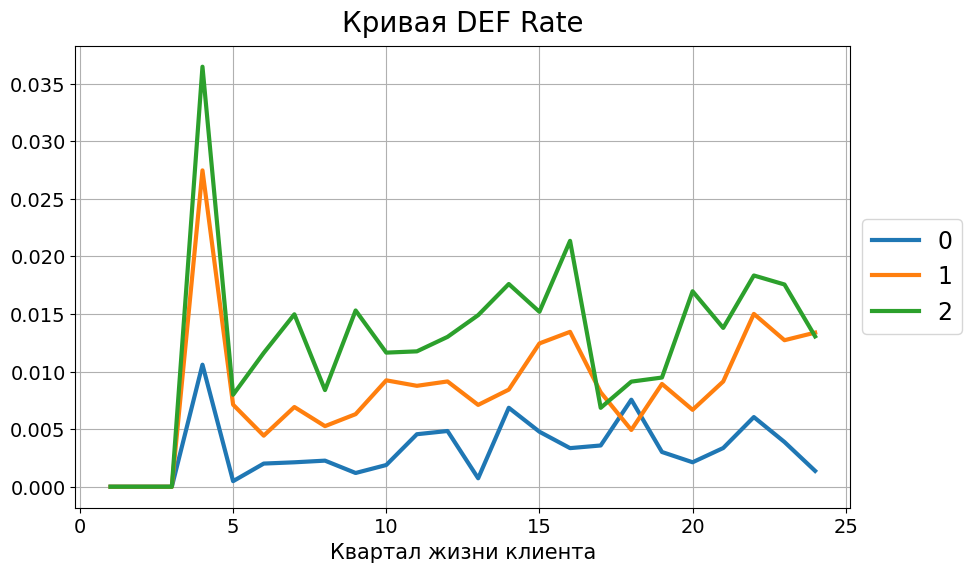

In [ ]:
def plot_def_rate_by_bucket(df, bucket):
    # для удобства отрисуем только по одному поколению-месяцу
    return df.query(''' gen_month_dt == '2019-04-01' ''').groupby([bucket, "statement_num"])\
                    .agg({"def_flg":np.sum, "def_flg":np.sum, "prev_def_flg": np.sum, "prev_act_flg": np.sum}) \
                    .rename(columns = {'def_flg': 'def_cnt', 'act_flg': 'act_cnt', 'prev_def_flg': 'prev_def_cnt', "prev_act_flg": "prev_act_cnt"}) \
                    .eval("def_rate = (def_cnt - prev_def_cnt) / prev_act_cnt").unstack(bucket)['def_rate'] \
                    .plot(ax=None, figsize=(10, 6), grid=True, lw = 3)


# сначала посмотрим на разделение по pd_bucket
plot_def_rate_by_bucket(df, 'pd_bucket')
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая DEF Rate", size=20, verticalalignment='bottom')
plt.xlabel("Квартал жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

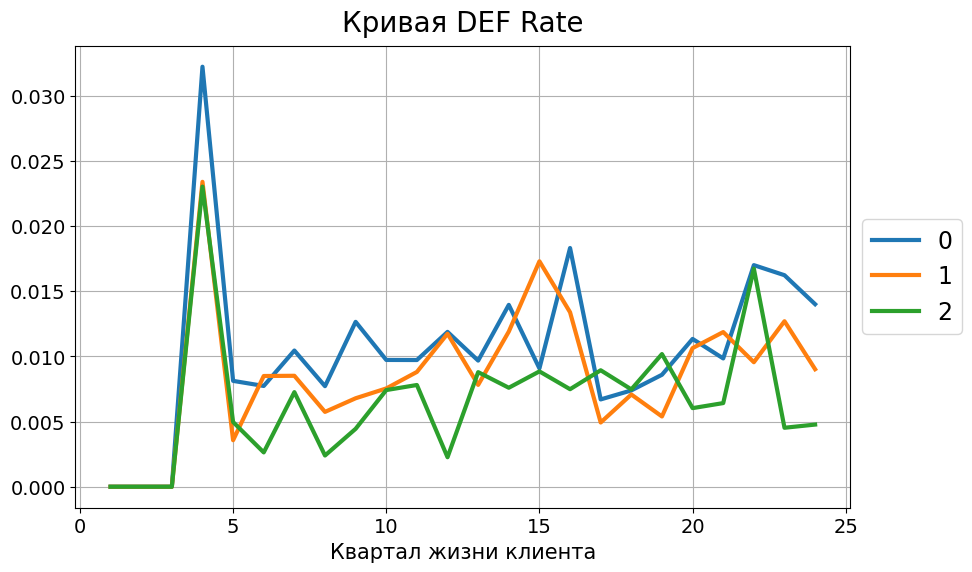

In [ ]:
# теперь взглянем на разделение по x_bucket
plot_def_rate_by_bucket(df, 'x_bucket')
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая DEF Rate", size=20, verticalalignment='bottom')
plt.xlabel("Квартал жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

Легко заметить, что разделение по pd_bucket идет гораздо лучше, чем по x_bucket (расстояние между кривыми в первом случае в среденем больше); следовательно дальше будем разделять именно по pd

### Анализ поколений (0.5 баллов)

Отрисуй распределение данных во времени в разбивке по выбранной перменной

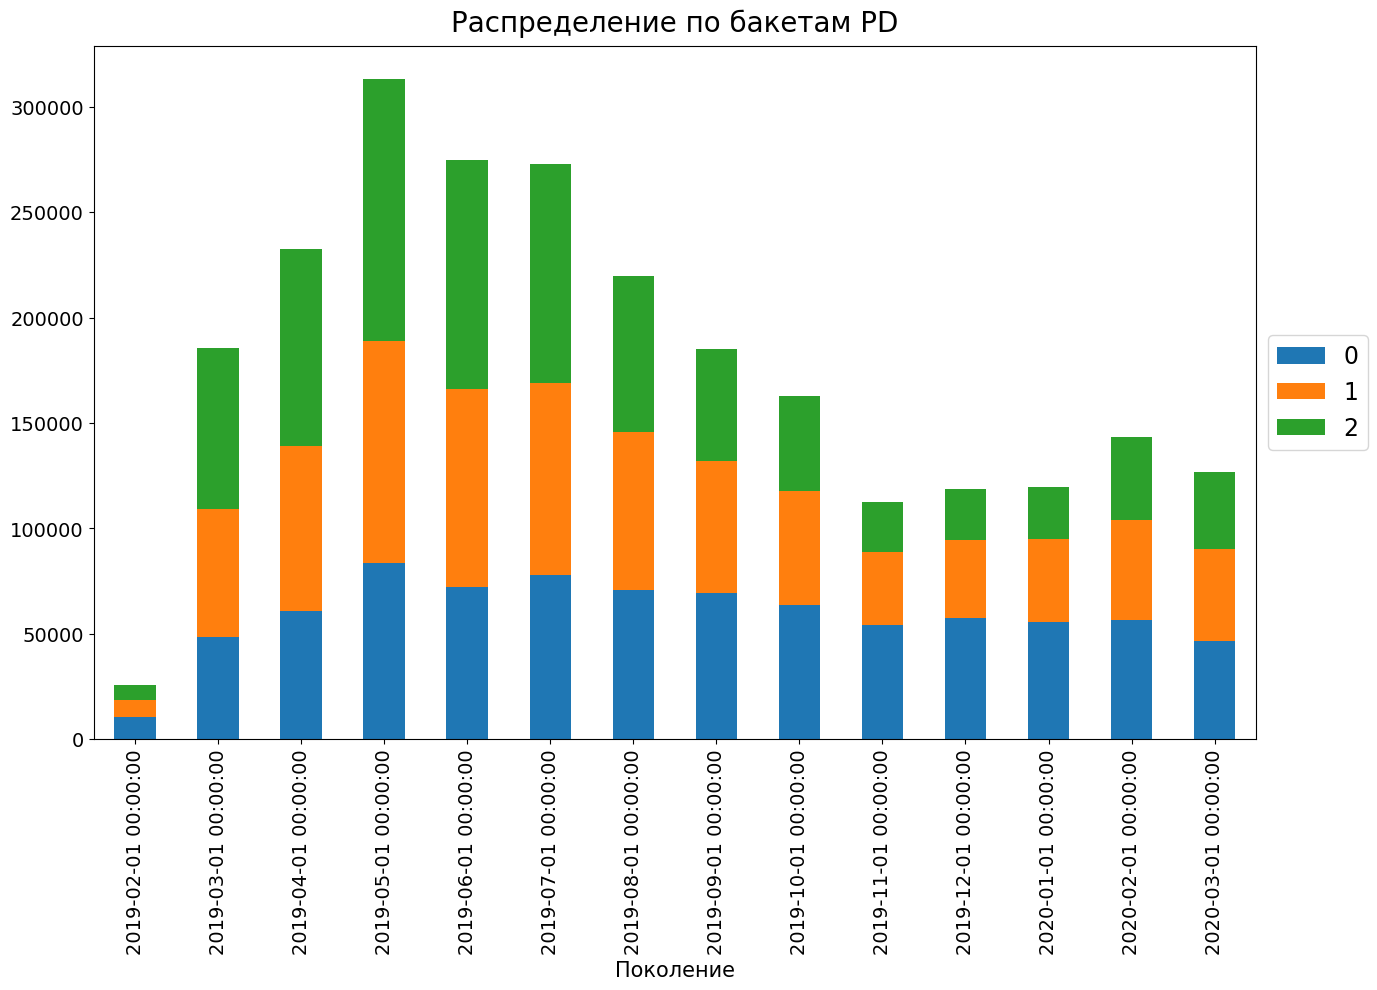

In [ ]:
def plot_distribution(df, bucket):
    return pd.pivot_table(df, index=[bucket], columns='gen_month_dt',          # делаем сводную таблицу и транспонируем ее
                values="user_id",
                aggfunc=np.count_nonzero, fill_value=0)\
               .T\
               .plot(kind='bar', stacked=True, figsize=(15, 9))                    # Рисуем график распределения столбиками

plot_distribution(df, 'pd_bucket')

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Распределение по бакетам PD", size=20, verticalalignment='bottom')
plt.xlabel("Поколение", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

Видно, что в феврале 2019 года мало наблюдений (25000 на три бакета по 24 платежа), а значит это поколение можно исключить из дальнейшего рассмотрения

In [ ]:
# Исключаем не очень хорошее поколение
exception_query = ''' ~((gen_month_dt == '2019-02-01')) '''
df.query(exception_query, inplace = True)

### Кривые DEF Rate в разбивке по бакетам (0.5 баллов)

Реализуй функцию, которая отрисовывает винтажи DEF rate в разбивке по бакетам

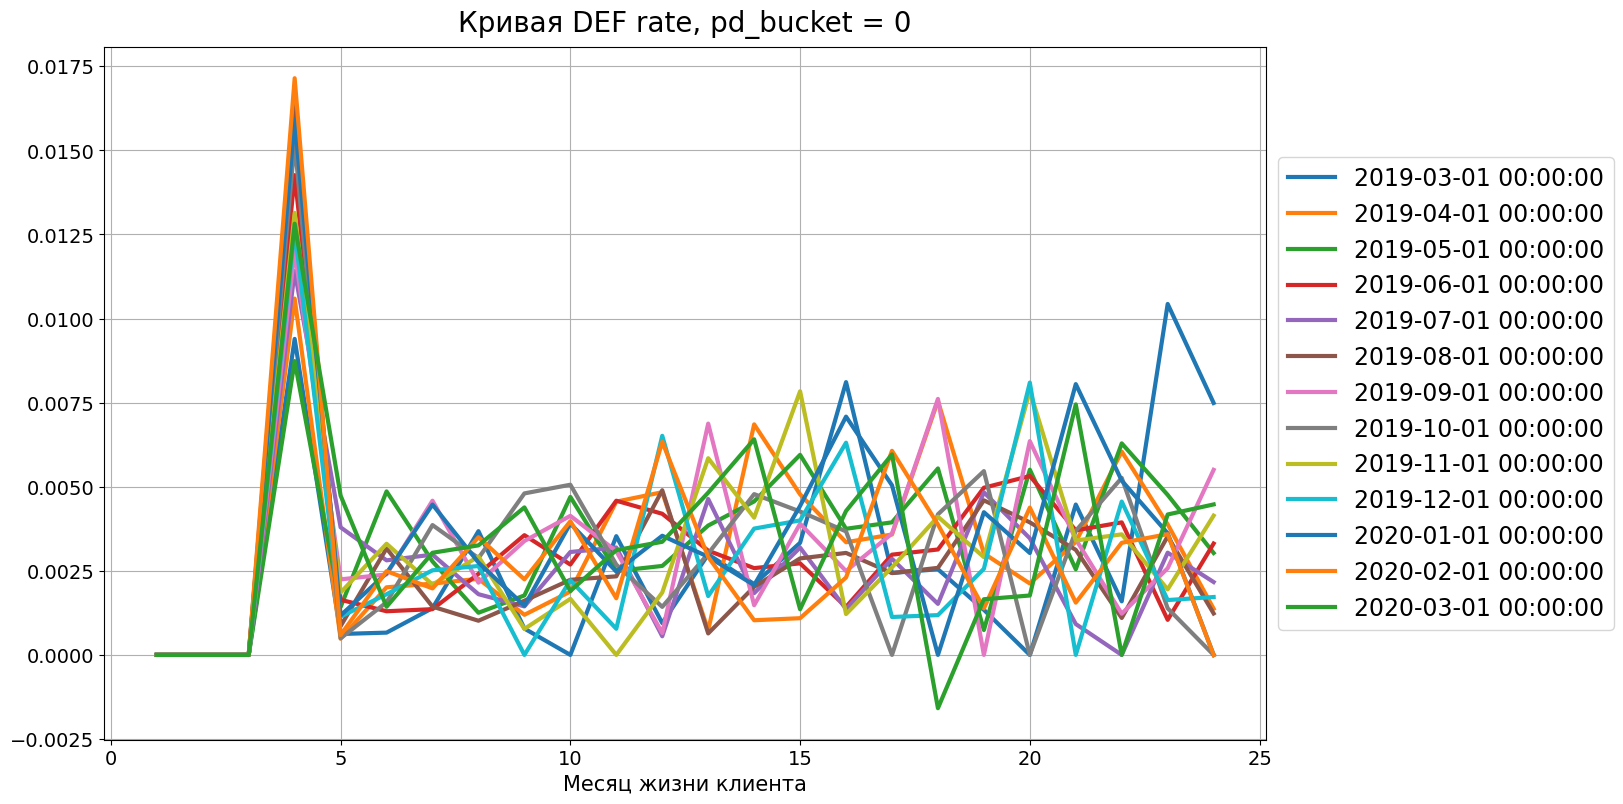

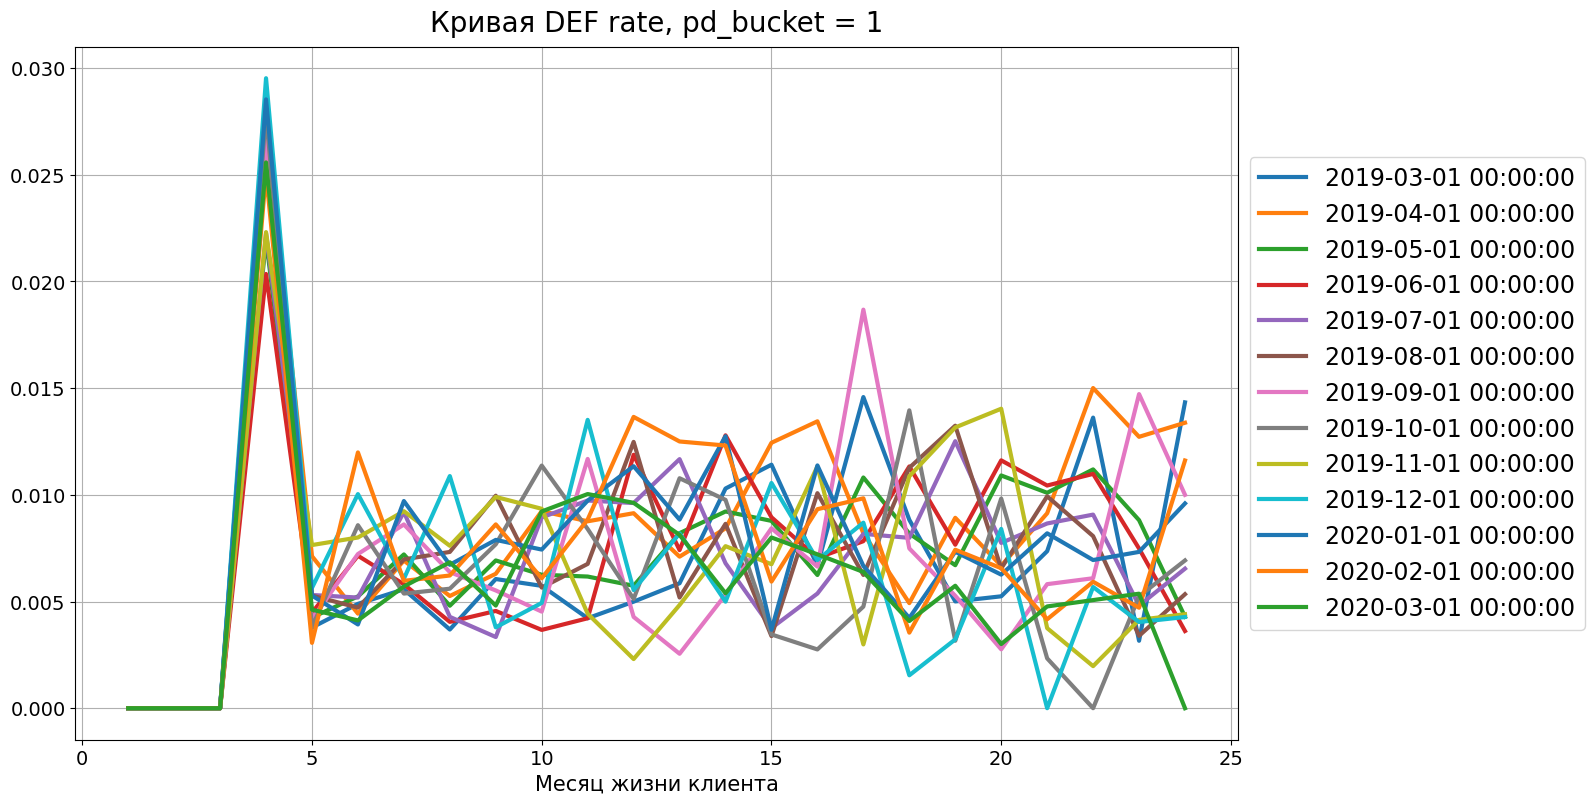

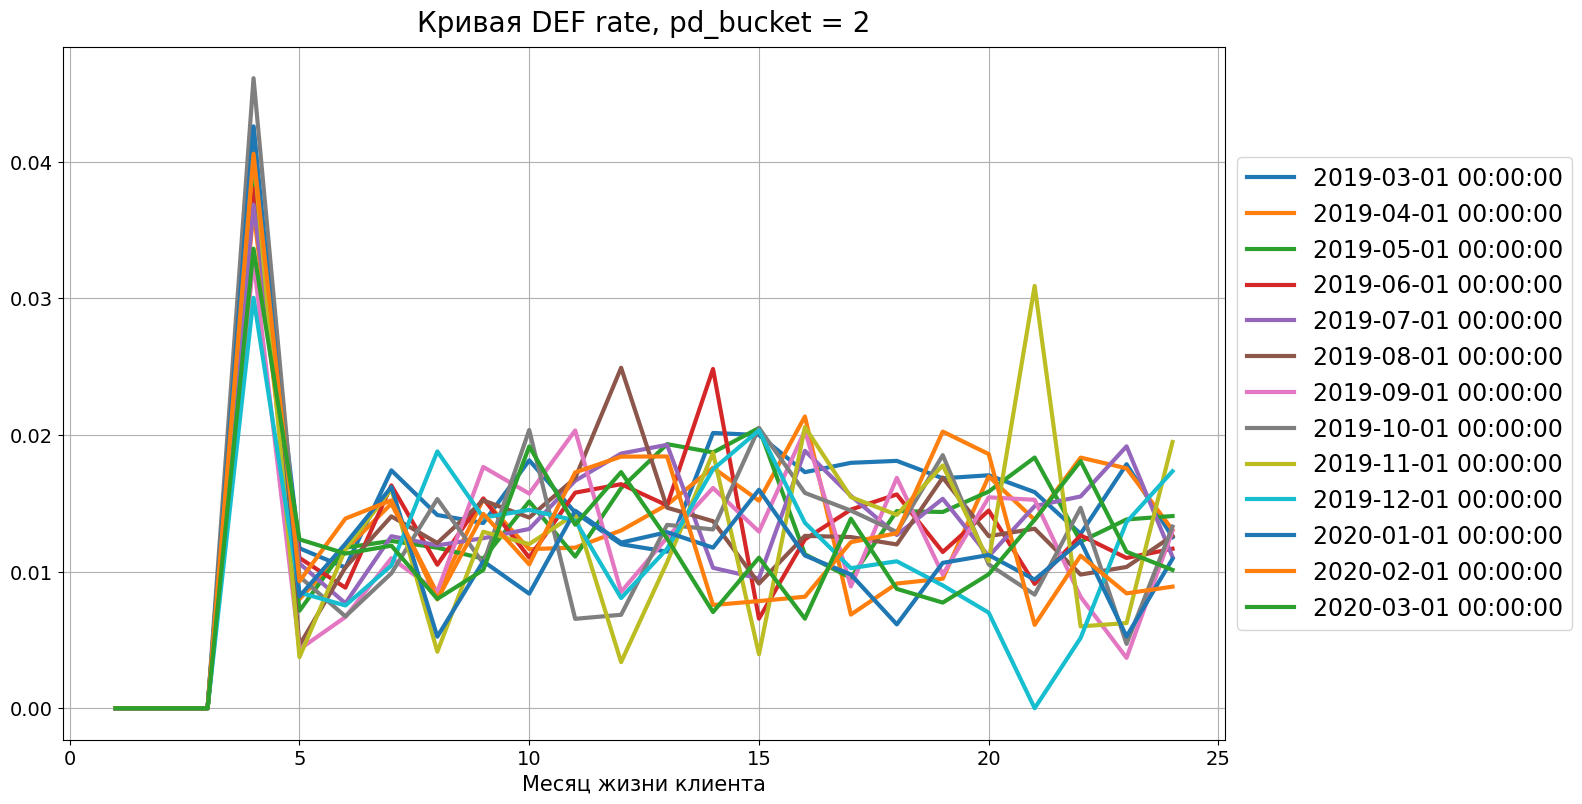

In [ ]:
# Делаем список бакетов
buckets = df['pd_bucket'].drop_duplicates().sort_values(ascending = True)


# Строим график, который зависит от бакета
def plot_def_rate_by_generation(data, pd_bucket):
    df_ = df.query('''pd_bucket == @pd_bucket''').groupby(["gen_month_dt", "statement_num"])\
                    .agg({"def_flg":np.sum, "def_flg":np.sum, "prev_def_flg": np.sum, "prev_act_flg": np.sum}) \
                    .rename(columns = {'def_flg': 'def_cnt', 'act_flg': 'act_cnt', 'prev_def_flg': 'prev_def_cnt', "prev_act_flg": "prev_act_cnt"}) \
                    .eval("def_rate = (def_cnt - prev_def_cnt) / prev_act_cnt").unstack('gen_month_dt')


    df_['def_rate'].plot(ax=None, figsize=(15, 9), grid=True, lw = 3)
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
    plt.title("Кривая DEF rate, pd_bucket = " + str(pd_bucket), size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.show()


for i in buckets:
    plot_def_rate_by_generation(df, i)


### Особые точки (0.5 баллов)
#### Есть ли в винтажах особые точки? Укажи их. Какова их природа? Нужно ли их исключать?

В винтажах по всем бакетам присутствует одна значимая особая точка - **4й месяц**, это фродовый пик, остальные являются выбросами, так как они не появляются регуляно по всем бакетам и поколениям; однако прежде чем исключать что-либо стоит сперва попробовать выделить влияние внешних факторов, которое возможно не так хорошо проявляет себя в графике выше

### Макроэкономические воздействие (2 балла)

#### Есть ли в винтажах DEF rate макроэкономическое воздействие (нарисуй график иллюстрирующее это воздействие)? Если да, то предположи какое событие его вызвало и почему?
#### В случае наличия внешнего влияния
#### 1) Разложи кривые на внешнее воздействие и созревание кривых
#### 2) Отрисуй график внешнего воздествия
#### 3) Отрисуй вычищенные винтажи def rate в разбивке по бакетам
#### 4) Посчитай среднее для этих бакетов и реализуй сглаживание

In [ ]:
def curve_build(data,
                feature,
                generation = 'generation_quart',
                statement_num = 'statement_num',
                group_label = '1'):

    """Вспомогательная функция для построения разложения в рамках одного бакета

    **Аргументы**
    data : pandas.DataFrame
        таблица с данными
    feature: str
        название поля с исследуемой переменной
    generation : datetime
        название поля с поколениями
    where : str
        условие, которым мы ограничиваем выборку
    statement_num : int
        название поля с номером месяца жизни клиента
    group_label : str
        название поля группы
    **Результат**
    dictionary : dict
    """

    df_query = data.sort_values([generation, statement_num]).reset_index()

    # Рассчитываем количество поколений и тому подобное
    generation_min = df_query[generation].min()
    gen_cnt = df_query[statement_num].max()

    # Преобразуем Dataframe в набор векторов
    values = np.array(df_query[feature])
    tab_size = df_query[feature].count()
    st_nums = np.array(df_query[statement_num] - 1)
    dates = np.array([0 for i in range(tab_size)])

    for i in range(tab_size):
         dates[i] = df_query.loc[i,generation].year * 12 + df_query.loc[i,generation].month -\
            generation_min.year * 12 - generation_min.month + df_query.loc[i,statement_num] - 1

    # Определяем функционал, который будем минимизировать

    def r_square(x):
        temp = 0
        for i in range(tab_size):
            if dates[i] >= 0:
                temp += (values[i] - x[dates[i]] * x[st_nums[i] + gen_cnt])**2
        return temp

    # Задаем callback для отслеживания прогресса минимизации
    def callbackF(Xi):
        global Nfeval
        print('%d  %.6f' % (Nfeval, r_square(Xi)))
        Nfeval += 1

    # Задаем начальное приближение в виде массива с нулевыми значениями

    x0 = np.array([0.00001 for i in range(2*gen_cnt)])                                # Внешние воздействия

    # Численная минимизация

    print('Initial %.6f' % (r_square(x0)))
    res0 = minimize(r_square, x0, tol=1e-6, callback=callbackF, method='Powell', options = {'disp': False, 'maxiter': 1000})

    # Задаем датафрейм с внешними воздействиями
    external_data = pd.DataFrame({'month_dt': [generation_min + pd.DateOffset(months = i) for i in range(gen_cnt)],
                             group_label: res0.x[:gen_cnt]})

    # Нормируем внешние воздействия таким образом, чтобы в среднем они равнялись единице.
    ext_mean = external_data[external_data['month_dt'] > generation_min + pd.DateOffset(months = 6)][group_label].mean()
    external_data[group_label] = external_data[group_label] / ext_mean

    # И умножаем на полученный коэффициент кривые созревания

    maturation_array = np.transpose([res0.x[gen_cnt:2* gen_cnt] * ext_mean]).flatten()
    maturation_data = pd.DataFrame(data = {group_label: maturation_array, \
                                           'statement_num': np.arange(1,maturation_array.size + 1)})

    df_fitted = df_query.merge(right=external_data, on = 'month_dt')
    df_fitted['fitted_feature'] = df_fitted[feature] / df_fitted[group_label]

    # Формируем словарь c итоговыми данными
    res = {'res0': res0,
          'external_data': external_data,
          'maturation_data': maturation_data,
          'df_fitted': df_fitted}
    return res


def decomposition(df,
                  generation = 'generation_month',
                  group = 'bucket',
                  statement_num = 'statement_num',
                  feature = 'feature',
                  optimization_query = ''):
    """Винтажи исследуемой переменной по календарному времени

    **Аргументы**
    df : pandas.DataFrame
        таблица с данными
    generation : datetime
        название поля с поколениями
    group : str
        название поля с бакетами
    statement_num : int
        название поля с номером выписки
    feature: str
        название поля с исследуемой переменной
    optimization_query: str
        ограничение выборки для оптимизации
    **Результат**
    dictionary : dict
    """

    # Разбираемся со случаем пустых аргументов

    if optimization_query == '':
        df_query = pd.DataFrame(df)
    else:
        df_query = df.query(optimization_query)

    timedelta = df_query[statement_num].apply(lambda x: pd.DateOffset(months=x-1))
    df_query['month_dt'] = pd.to_datetime(df_query[generation] + timedelta)

      # Формируем список бакетов

    df_query.sort_values(by = [group], inplace = True)
    groups = pd.Series(df_query[group].drop_duplicates())

    # Запускаем цикл по бакетам
    i = 0
    for g in groups:
        df_temp = df_query[df_query[group] == g]
        print(group + ' = ' + str(g))

        # Строим разложение для одного бакета
        res = curve_build(df_temp,
                          feature = feature,
                          generation = generation,
                          statement_num = statement_num,
                          group_label = str(g)
                         )
        df_fitted_temp = pd.DataFrame(res['df_fitted'])
        df_fitted_temp[group] = g

        # Если первый шаг в цикле, то формируем датафреймы из результатов минимизации
        if i == 0:
            external_data = pd.DataFrame(res['external_data'])[['month_dt', str(g)]]
            maturation_data = pd.DataFrame(res['maturation_data'])[[statement_num, str(g)]]
            df_fitted = pd.DataFrame(df_fitted_temp)
        # Если шаг не первый, то дописываем столбцы в результаты
        else:
            external_data = external_data.merge(right = res['external_data'], on = ['month_dt'])
            maturation_data = maturation_data.merge(right = res['maturation_data'], on = [statement_num])
            df_fitted = pd.concat([df_fitted, df_fitted_temp])
        i+=1

    res_multiple = {
                    'external_data': external_data,
                    'maturation_data': maturation_data,
                    'fitted_data': df_fitted
                   }
    return res_multiple

In [ ]:
# Подготавливаем данные
df_rate = df.groupby(["pd_bucket", "gen_month_dt", "statement_num"])\
                    .agg({"def_flg":np.sum, "def_flg":np.sum, "prev_def_flg": np.sum, "prev_act_flg": np.sum}) \
                    .rename(columns = {'def_flg': 'def_cnt', 'act_flg': 'act_cnt', 'prev_def_flg': 'prev_def_cnt', "prev_act_flg": "prev_act_cnt"}) \
                    .eval("def_rate = (def_cnt - prev_def_cnt) / prev_act_cnt").reset_index()

# Счетчик итераций
Nfeval = 0

# Проводим разложение кривых
res = decomposition(df_rate,
                    generation = 'gen_month_dt',
                    group = 'pd_bucket',
                    statement_num = 'statement_num',
                    feature = 'def_rate')

<ipython-input-14-1736d24dd3a5>:124: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  df_query['month_dt'] = pd.to_datetime(df_query[generation] + timedelta)


pd_bucket = 0
Initial 0.005636
0  0.001567
1  0.001503
2  0.001503
3  0.001502
4  0.001502
5  0.001502
6  0.001502
7  0.001502
8  0.001502
9  0.001502
10  0.001502
11  0.001502
pd_bucket = 1
Initial 0.025083
12  0.005290
13  0.005109
14  0.005104
15  0.005098
16  0.005098
17  0.005098
18  0.005098
19  0.005098
20  0.005098
pd_bucket = 2
Initial 0.066938
21  0.014598
22  0.013826
23  0.013751
24  0.013716
25  0.013700
26  0.013692
27  0.013689
28  0.013687
29  0.013686
30  0.013686
31  0.013686
32  0.013686
33  0.013686
34  0.013686
35  0.013686


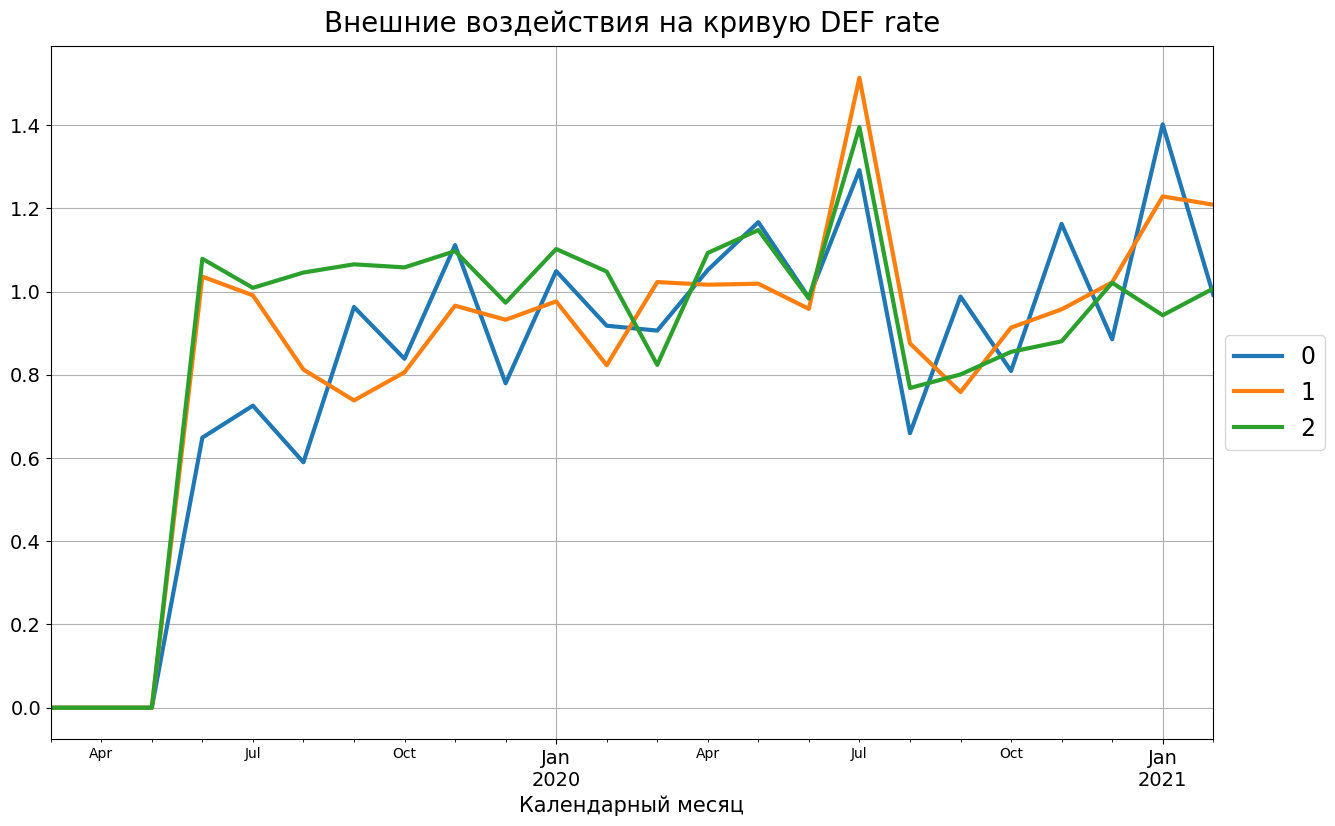

In [ ]:
res['external_data'].set_index('month_dt')\
                    .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Внешние воздействия на кривую DEF rate", size=20, verticalalignment='bottom')
plt.xlabel("Календарный месяц", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

Хорошо выделяется резкий скачок в конце весны 2020-го года; очевидно, что это связано с ковидом. Других приметных внешенэкономических воздействий не наблюдается.

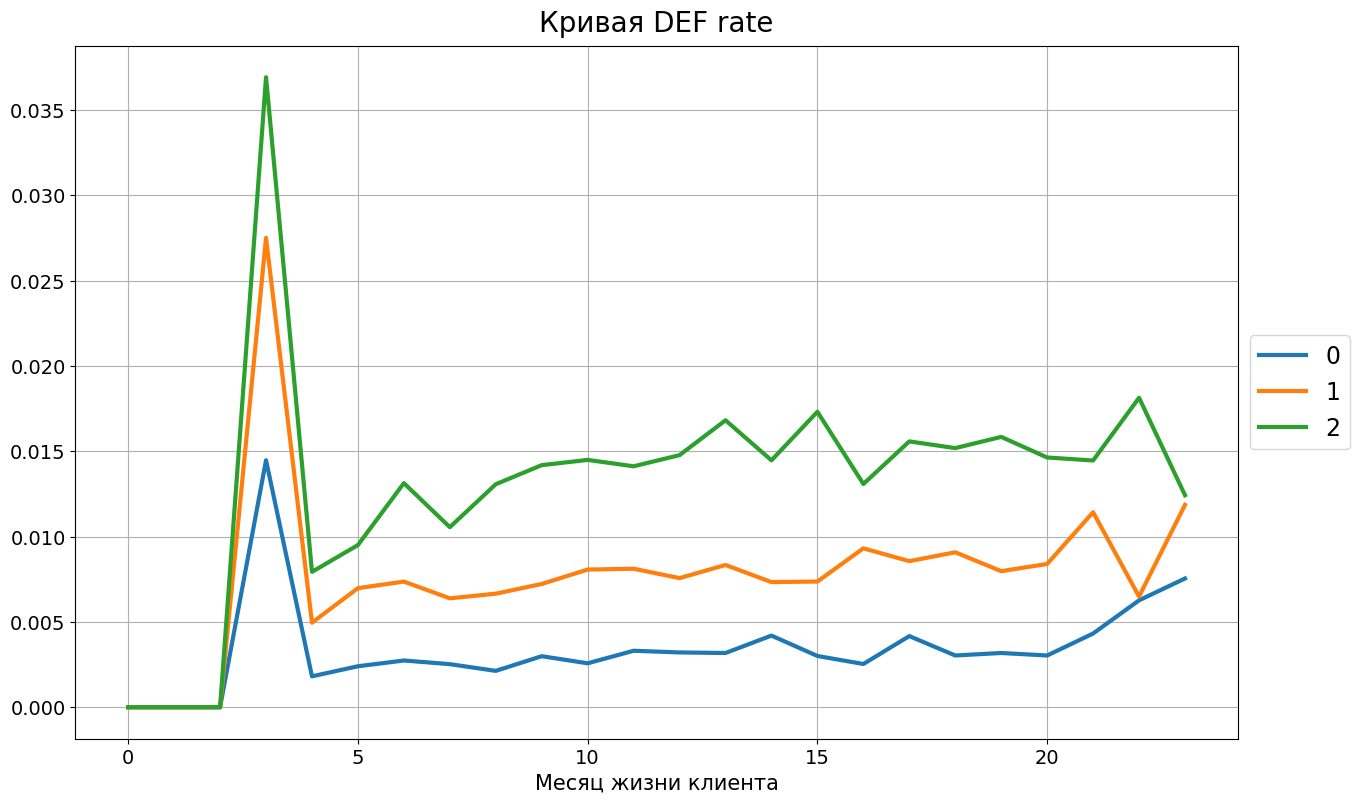

In [ ]:
res['maturation_data'].drop('statement_num', axis=1).plot(ax=None, figsize=(15, 9), grid=True, lw = 3)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая DEF rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

### Среднее по бакетам (0.5 баллов)
Выбери один из способой нахождение средней кривой (возможные способы указаны в лекции). Обоснуй свой выбор.

Реализуй функцию построения среднего.

Попробуем сравнить результаты при использовании обычного среднего и медианы

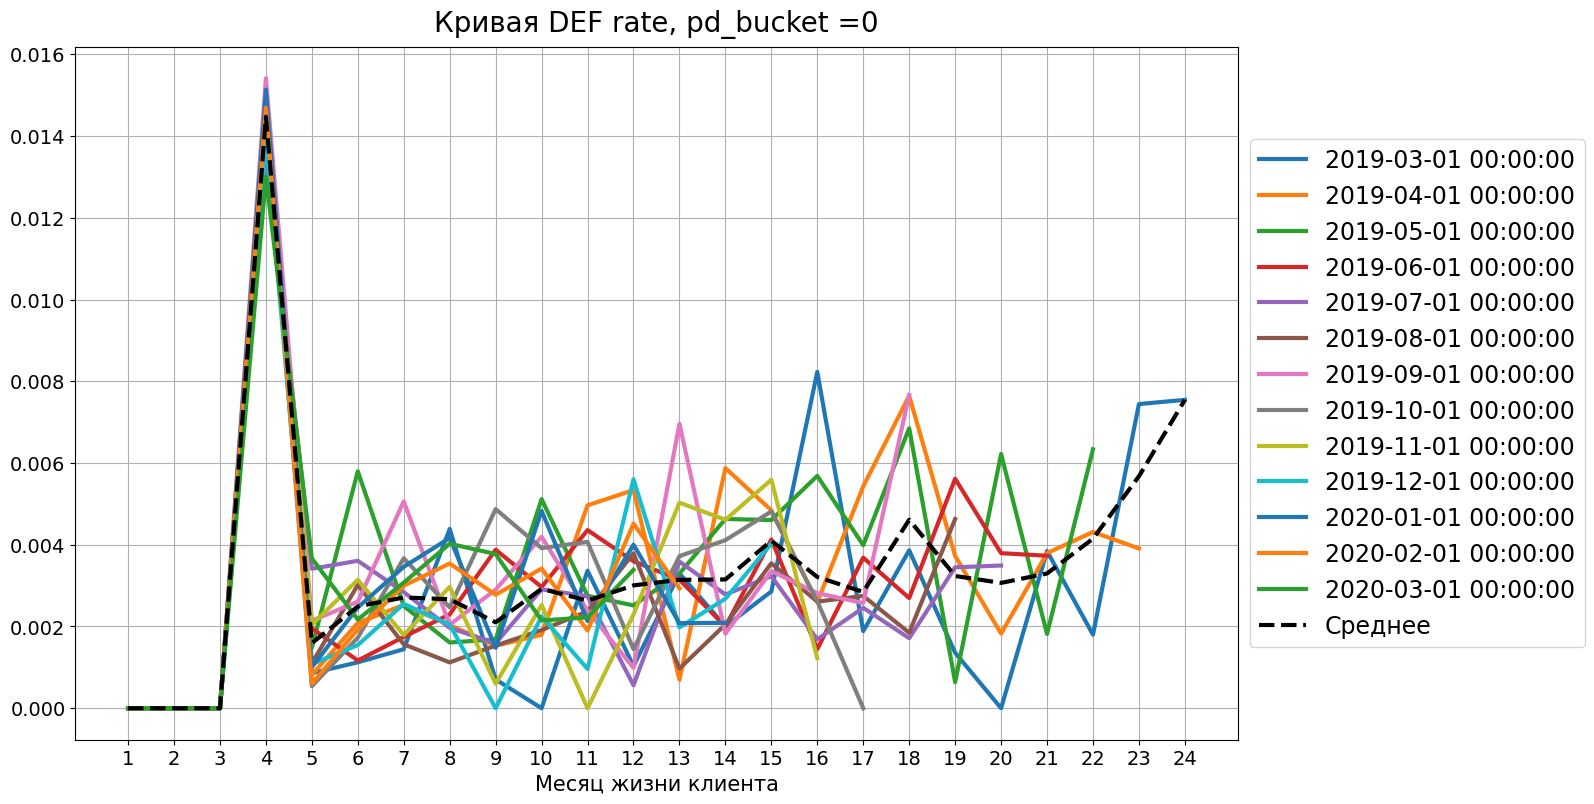

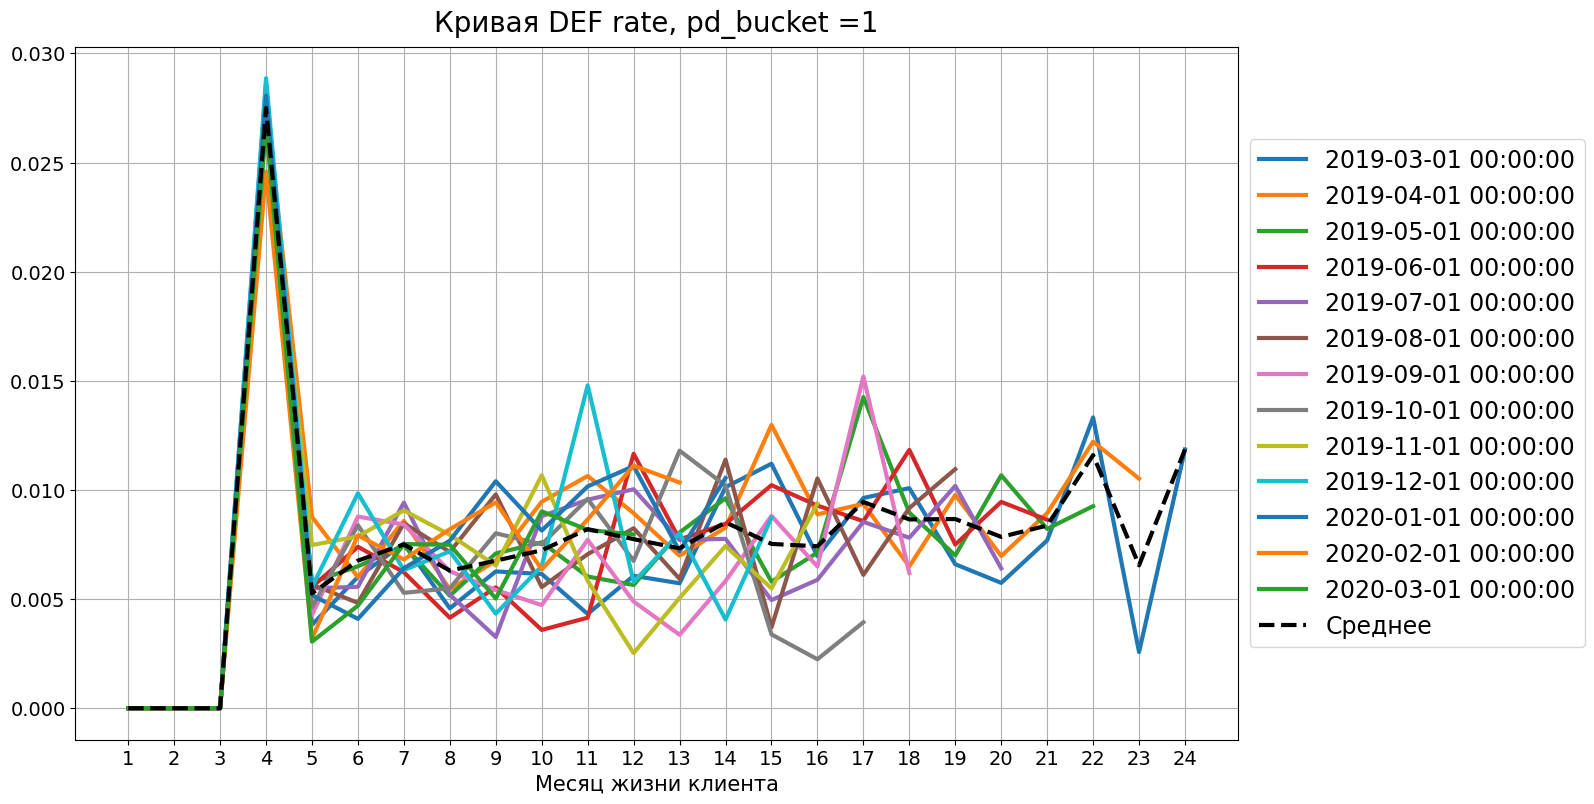

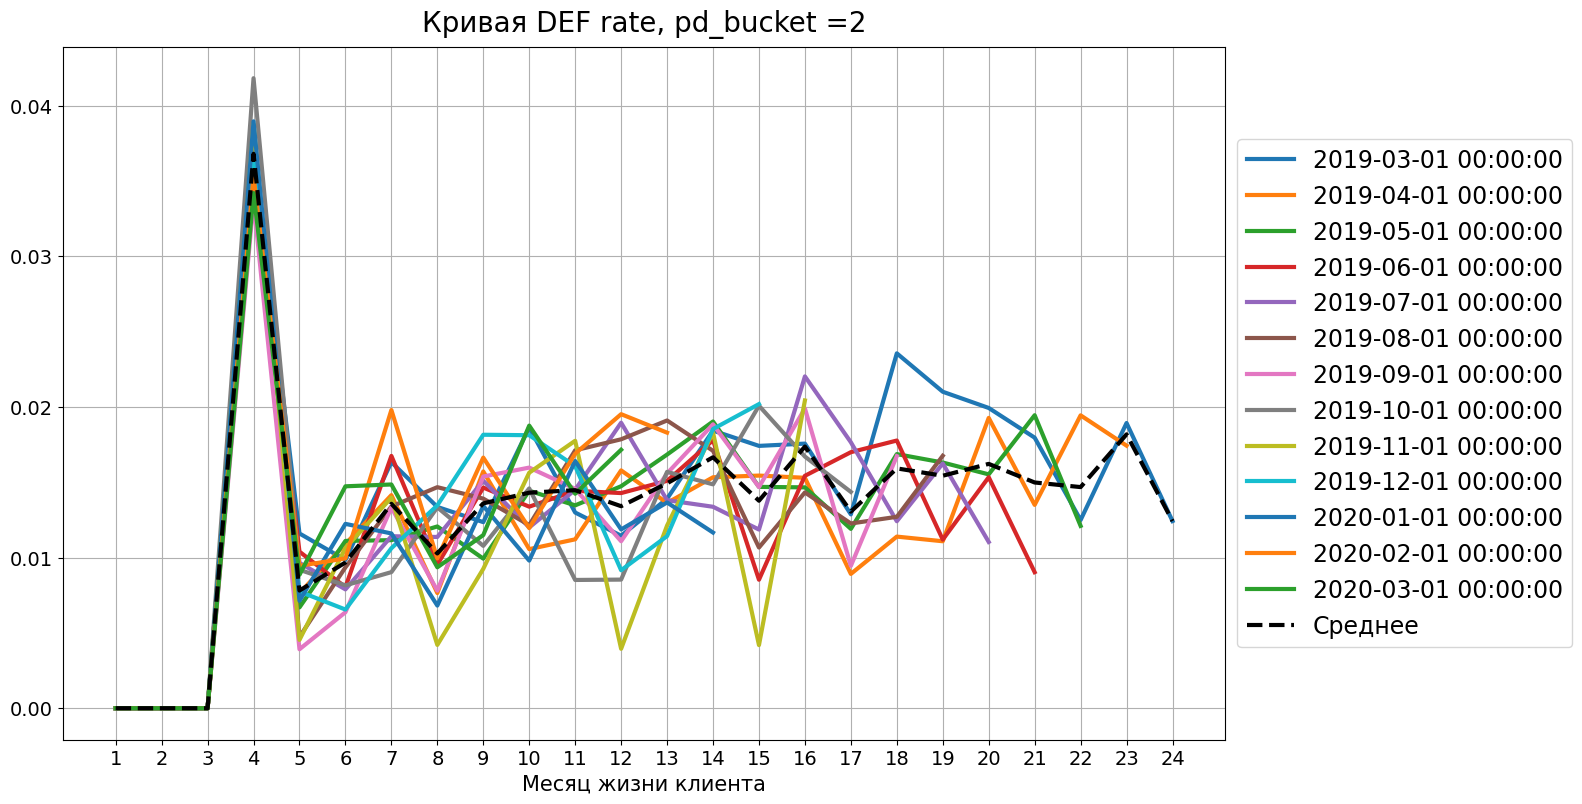

In [ ]:
# Считаем среднее
def_rate_mean = res['fitted_data'].groupby([ 'pd_bucket', 'statement_num'])\
    .agg({'fitted_feature':np.mean})\
    .rename(columns = {'fitted_feature':'Среднее'})

buckets = df['pd_bucket'].drop_duplicates()

# Строим графики винтажей и среднего

def plot_def_rate_mean(pd_bucket):
    res['fitted_data'][0] = 0
    vintages_graph = res['fitted_data'].query('pd_bucket == ' + str(pd_bucket))\
            .groupby(["gen_month_dt", "statement_num"])\
            .agg({"fitted_feature":np.sum})\
            .unstack('gen_month_dt')\
            ['fitted_feature']\
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3) # график винтажей

    (def_rate_mean.query('pd_bucket == ' + str(pd_bucket))['Среднее'][pd_bucket]
             .plot( figsize=(15, 9), grid=True, lw = 3, color = 'Black', ls = 'dashed')) # Подаем график винтажей в ось другого, чтобы отобразить их вместе

    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
    plt.title("Кривая DEF rate, pd_bucket =" + str(pd_bucket), size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.xticks(np.arange(1, 25))

for i in sorted(buckets):
    plot_def_rate_mean(i)



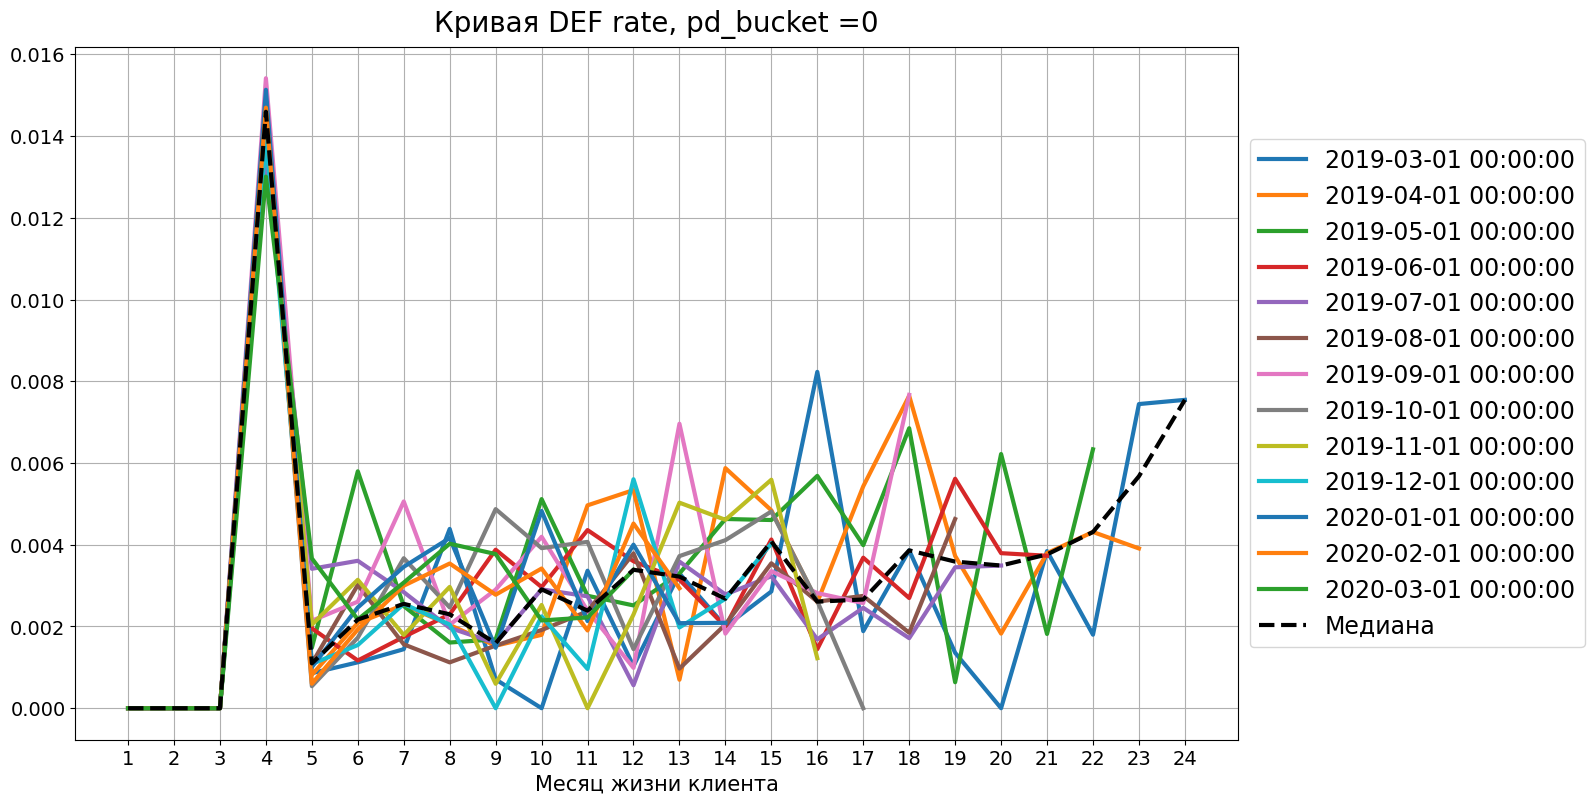

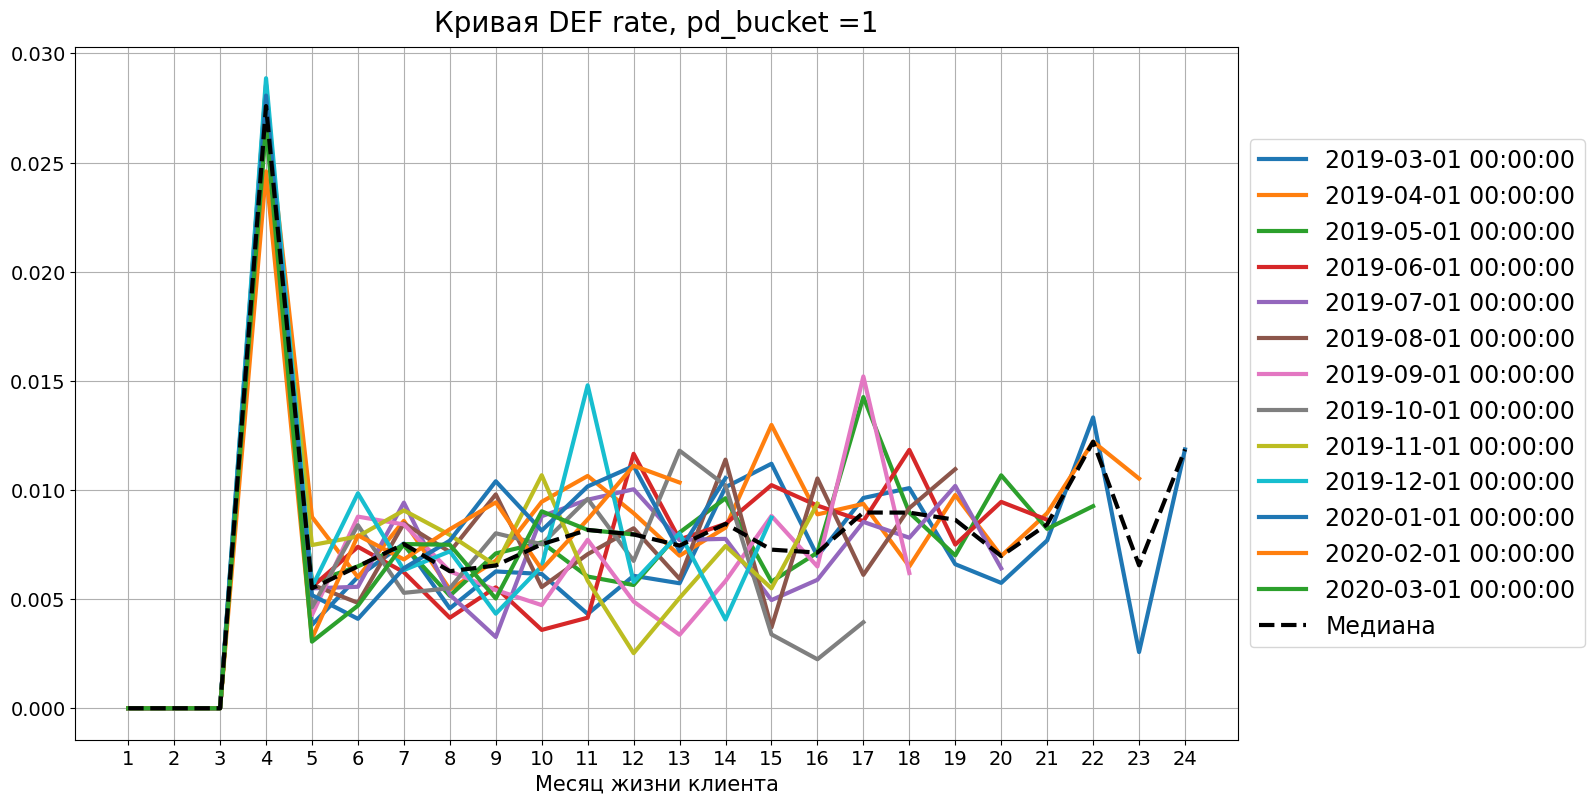

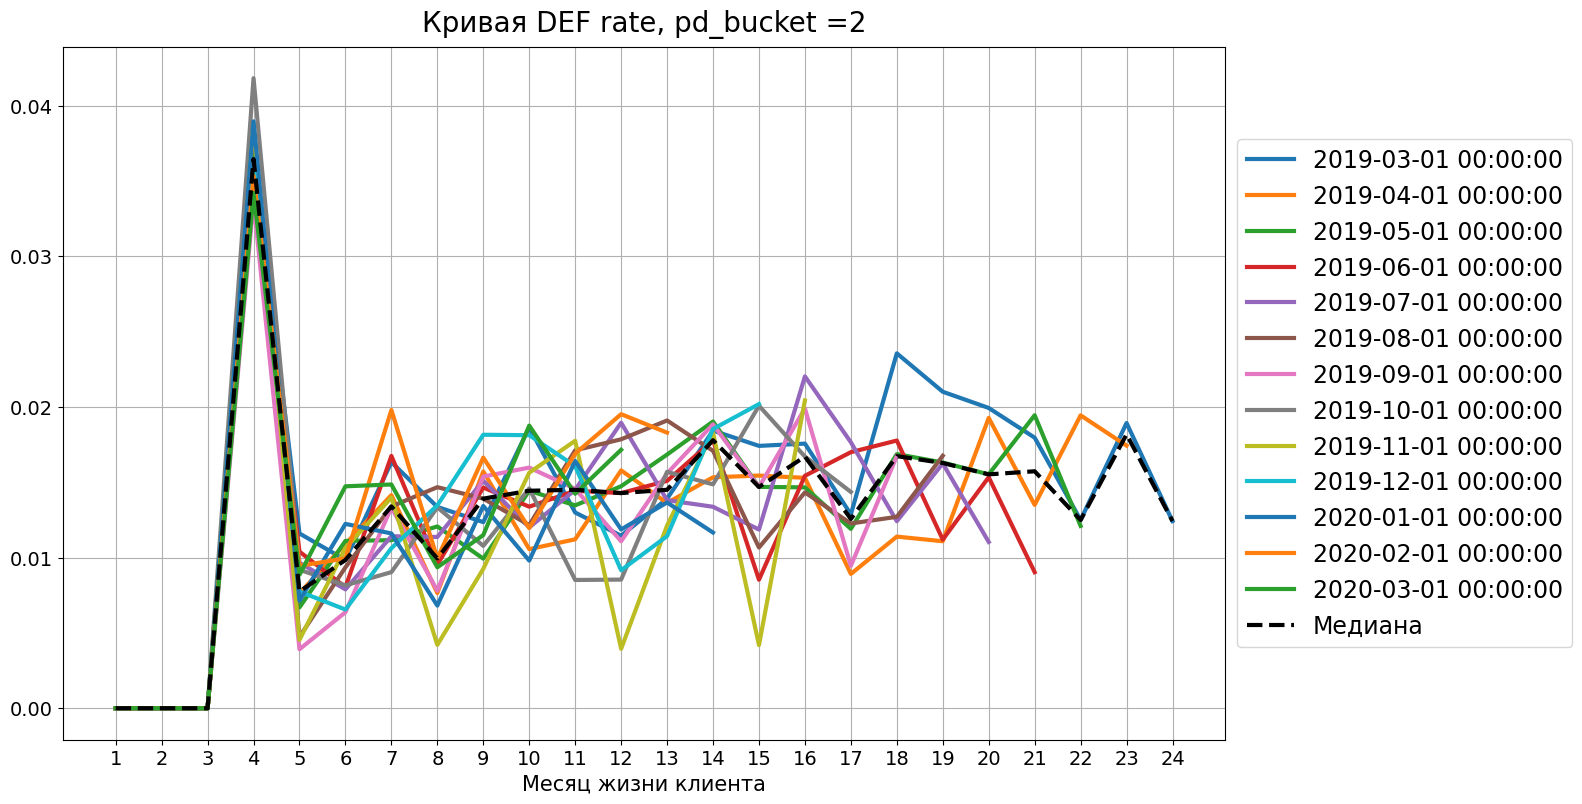

In [ ]:
# Считаем среднее
def_rate_median = res['fitted_data'].groupby([ 'pd_bucket', 'statement_num'])\
    .agg({'fitted_feature':np.median})\
    .rename(columns = {'fitted_feature':'Медиана'})

buckets = df['pd_bucket'].drop_duplicates()

# Строим графики винтажей и среднего

def plot_def_rate_mean(pd_bucket):
    res['fitted_data'][0] = 0
    vintages_graph = res['fitted_data'].query('pd_bucket == ' + str(pd_bucket))\
            .groupby(["gen_month_dt", "statement_num"])\
            .agg({"fitted_feature":np.sum})\
            .unstack('gen_month_dt')\
            ['fitted_feature']\
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3) # график винтажей

    (def_rate_median.query('pd_bucket == ' + str(pd_bucket))['Медиана'][pd_bucket]
             .plot( figsize=(15, 9), grid=True, lw = 3, color = 'Black', ls = 'dashed')) # Подаем график винтажей в ось другого, чтобы отобразить их вместе

    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
    plt.title("Кривая DEF rate, pd_bucket =" + str(pd_bucket), size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.xticks(np.arange(1, 25))

for i in sorted(buckets):
    plot_def_rate_mean(i)



По картинкам каких-то очень сильных различий в целом не наблюдается, но кажется что среднее будет немного лучше подстраивается под более свежие данные, поэтому будем считать именно его

### Сглаживание средних кривых (0.5 баллов)

Рассмотри несколько функций для сглаживания кривой (можешь взять готовые из семинара, либо реализовать свои).

In [ ]:
def linear_approximation(df, start=1, finish=24):
    df_res = pd.DataFrame(df)
    df_res['Линейная функция'] = df['Среднее']                                                # Копируем средние значения
    linear_coeff = np.polyfit(np.arange(start, finish+1),df.loc[start:finish, 'Среднее'], 1)  # Коэффициенты уравнения прямой
    linear_coeff = np.poly1d(linear_coeff)                                                    # Превращаем коэффициенты в функцию
    df_res.loc[start:finish, 'Линейная функция'] = linear_coeff(np.arange(start, finish+1))   # Записываем приближение
    df_res.loc[finish+1:, 'Линейная функция'] = linear_coeff(finish+1)                        # Продолжаем кривую константой
    return df_res

def polynom_approximation(df, start=1, finish=20, degree = 1):
    df_res = pd.DataFrame(df)
    df_res['Полином'] = df['Среднее']
    linear_coeff = np.polyfit(np.arange(start, finish+1),df.loc[start:finish, 'Среднее'], degree)  # Здесь произвольная степень
    linear_coeff = np.poly1d(linear_coeff)
    df_res.loc[start:finish, 'Полином'] = linear_coeff(np.arange(start, finish+1))
    df_res.loc[finish+1:, 'Полином'] = linear_coeff(finish+1)
    return df_res

def exponential_smoothing(df, start, finish, alpha):
    df_res = pd.DataFrame(df)
    result = [df_res.loc[i,'Среднее'] for i in np.arange(1, start+1)]                              # Начальные значения копируем
    for n in range(start, len(df_res['Среднее'])):
        result.append(float(alpha * df_res.loc[n + 1, 'Среднее'] + (1 - alpha) * result[n-1]))    # Делаем сглаживание
    df_res['Скользящее среднее'] = result
    return df_res

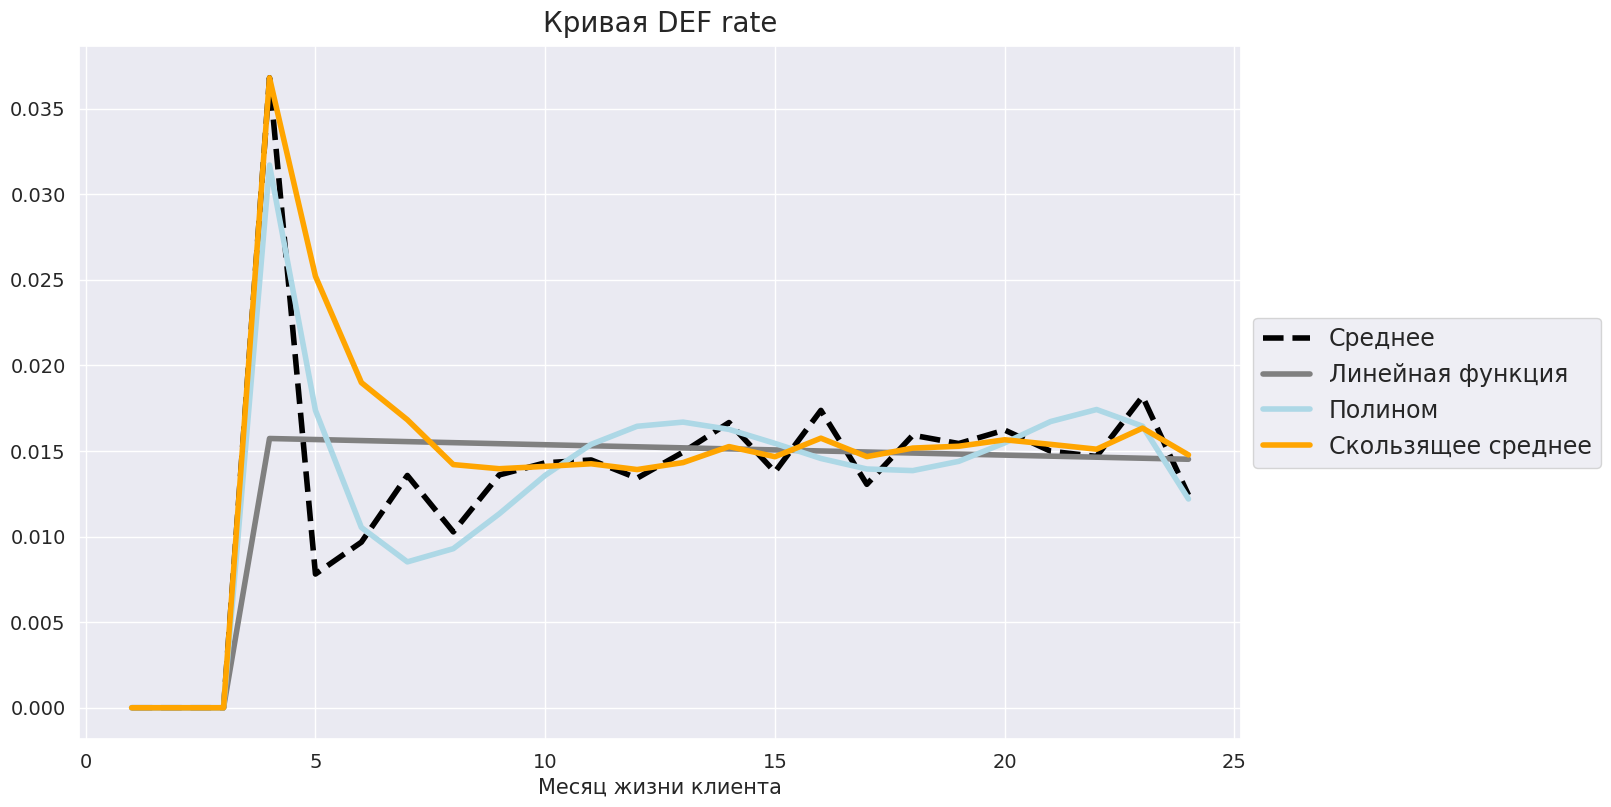

In [ ]:
def_rate_mean = res['fitted_data'].groupby([ 'pd_bucket', 'statement_num'])\
    .agg({'fitted_feature':np.mean})\
    .rename(columns = {'fitted_feature':'Среднее'})

df_linear = def_rate_mean.query('pd_bucket == 2').reset_index().set_index(['statement_num'])
df_linear = linear_approximation(df_linear, 4, 24)
df_polynom = polynom_approximation(df_linear, 4, 24, 5)
df_smooth = exponential_smoothing(df_polynom, 4,24, 0.4)

# Строим получившиеся графики
plt.figure(figsize=(15, 9))
df_smooth['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
df_smooth['Линейная функция'].plot(grid=True, color = 'Gray', linestyle = '-', lw = 4)
df_smooth['Полином'].plot(grid=True, color = 'LightBlue', linestyle = '-', lw = 4)
df_smooth['Скользящее среднее'].plot(grid=True, color = 'Orange', linestyle = '-', lw = 4)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая DEF rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

#### Вывод: укажи выбранную функцию и обоснуй свой выбор. Были ли точки, к которым не применил сглаживание? Почему?

Кажется, что аппрокимация полином 5-ой степени выглядит неплохо, позволяя улавливать колебания кривой (периоды спада и роста def_rate), при этом не чересчур подстраиваясь под непосредственные данные. Линейная аппроксимация выглядит прям совсем плохо на этом фоне (банально даже сильно занижая фродовой пик 4-го месяца), тогда как скользящее среднее при маленьком значении коэффициента сглаживания не позволяет ухватывать те самые колебания rate, а при большом значении - сильно подстраивается под данные

### Отрисуй сглаженные кривые по всем трем бакетам PD

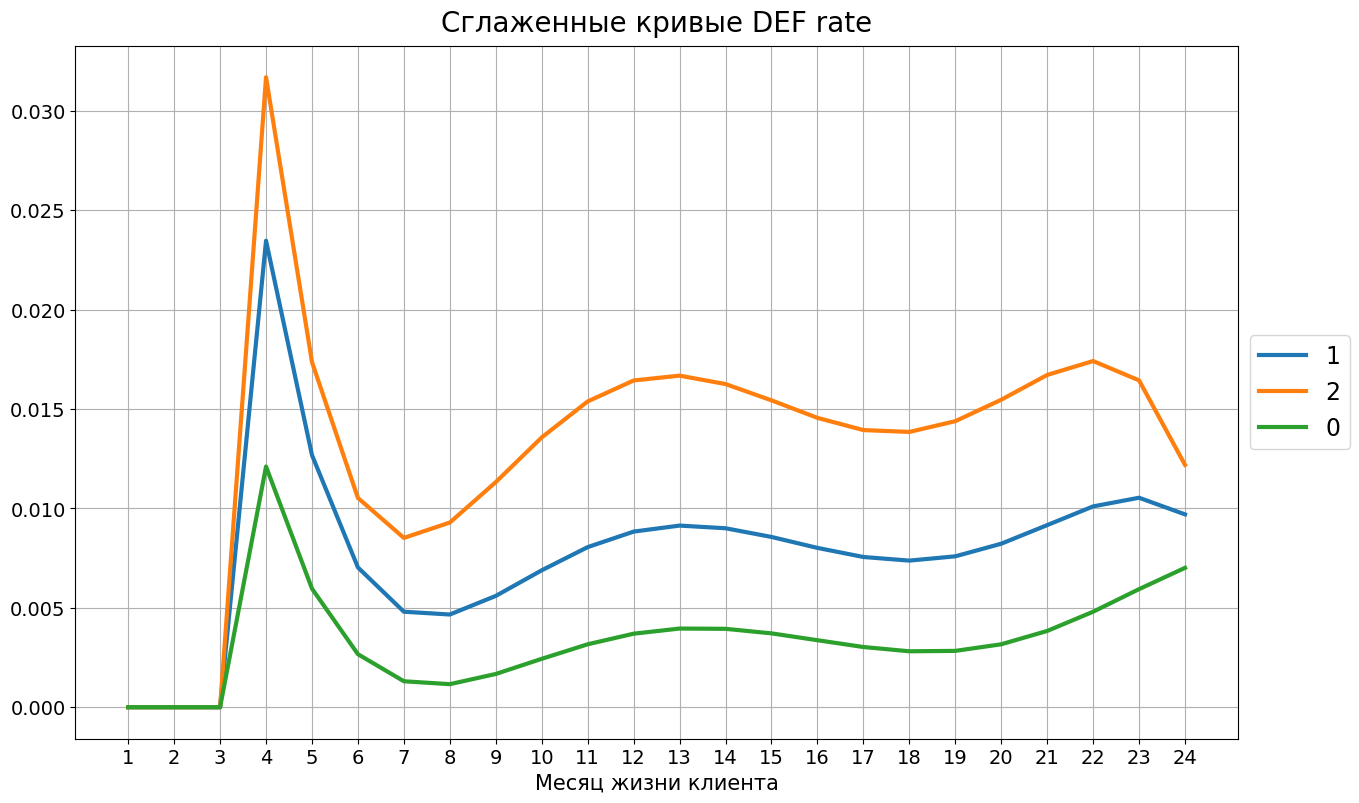

In [ ]:
# Запоминаем набор бакетов и заводим пустой датафрейм под результат

buckets = df['pd_bucket'].drop_duplicates()
df_smooth_result = pd.DataFrame()

# Далем полиномиальное сглаживание для каждого бакета
for bucket in buckets:
    df_temp = def_rate_mean.query('pd_bucket == ' + str(bucket)).reset_index().set_index(['statement_num'])
    df_smooth_result[str(bucket)] = polynom_approximation(df_temp, 4, 24, 5)['Полином']

# Строим итоговый график
df_smooth_result.plot(figsize=(15, 9), grid=True, lw = 3)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Сглаженные кривые DEF rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.xticks(np.arange(1, 25))
plt.tick_params(axis='both', which='major', labelsize=14)

In [ ]:
df_scores = df_scores.sort_values(['pd'], ignore_index=True)
df_scores['pd_bucket'] = np.minimum(df_scores.index // (df_scores.shape[0]//3),2)
pd_buckets = df_scores.groupby(['pd_bucket'])['pd'].mean()

In [ ]:
df_smooth_result.loc[0] = pd_buckets[[1,2,0]].values
df_smooth_result.sort_index()

1         2         0
statement_num                              
0              0.032685  0.068209  0.011040
1              0.000000  0.000000  0.000000
2              0.000000  0.000000  0.000000
3              0.000000  0.000000  0.000000
4              0.023472  0.031700  0.012110
5              0.012687  0.017370  0.005967
6              0.007033  0.010529  0.002667
7              0.004805  0.008520  0.001306
8              0.004665  0.009292  0.001160
9              0.005601  0.011328  0.001673
10             0.006889  0.013576  0.002435
11             0.008056  0.015386  0.003167
12             0.008837  0.016441  0.003700
13             0.009140  0.016684  0.003959
14             0.009005  0.016261  0.003945
15             0.008568  0.015441  0.003716
16             0.008017  0.014560  0.003372
17             0.007559  0.013945  0.003030
18             0.007377  0.013851  0.002814
19             0.007592  0.014392  0.002835
20             0.008227  0.015471  0.003167
21             0.009163  0.016719  0.003838
22             0.010105  0.017419  0.004805
23             0.010541  0.016446  0.005941
24             0.009703  0.012194  0.007014

In [ ]:
df_smooth_result.sort_index().to_csv('def_rate.csv')

# CLO rate

### Выбери переменную, которая делит кривые наилучшим образом (0.5 баллов)

 Из двух скоров (x_score и ваш PD) выбери тот, который разделяет кривые наилучшим образом

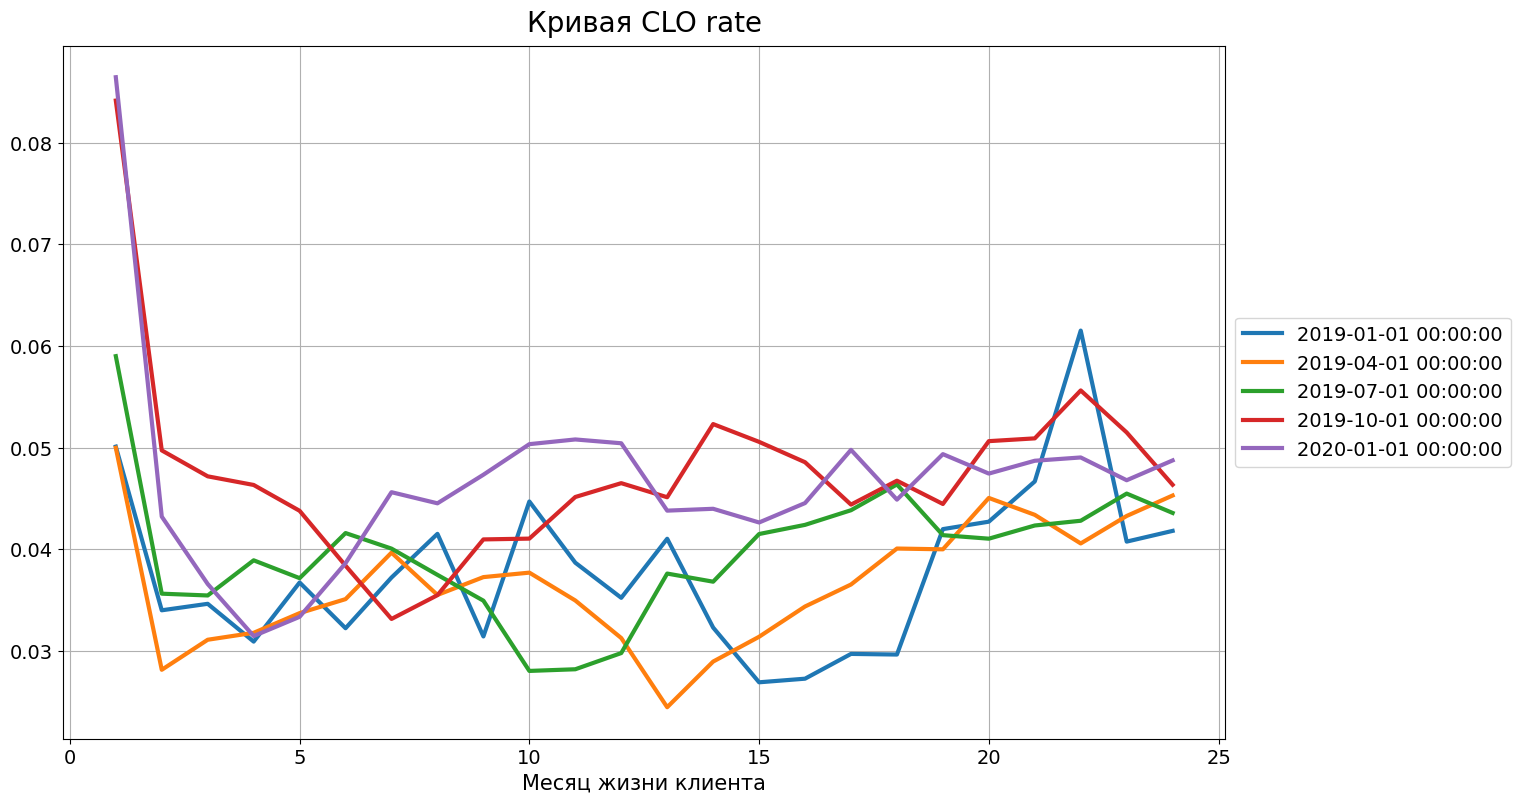

In [ ]:
def plot_clo_rate_by_bucket(df):
    # будем рисовать кривые по месяцам, как и раньше
    return df.groupby(["gen_quarter_dt", "statement_num"])\
           .agg({"clo_flg":np.sum, "clo_flg":np.sum, "prev_clo_flg": np.sum, "prev_act_flg": np.sum}) \
           .rename(columns = {'clo_flg': 'clo_cnt', 'act_flg': 'act_cnt', 'prev_clo_flg': 'prev_clo_cnt', "prev_act_flg": "prev_act_cnt"}) \
           .eval("clo_rate = (clo_cnt - prev_clo_cnt) / prev_act_cnt").unstack('gen_quarter_dt')['clo_rate'] \
           .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)


# Строим график при помощи pyplot
plot_clo_rate_by_bucket(df)

# Настраиваем параметры отображения графика
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '14')
plt.title("Кривая CLO rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

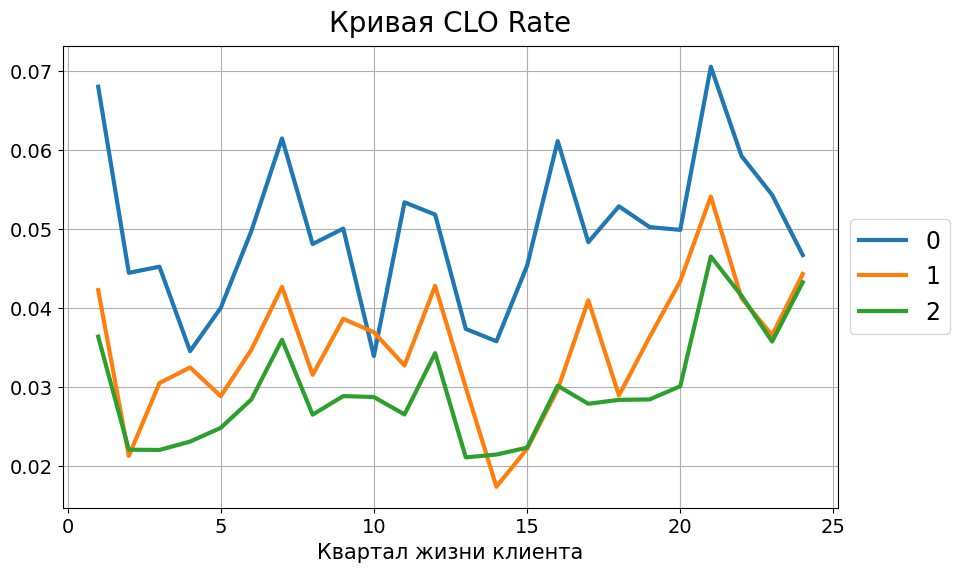

In [ ]:
def plot_clo_rate_by_bucket(df, bucket):
    return df.query(''' gen_month_dt == '2019-04-01' ''').groupby([bucket, "statement_num"])\
           .agg({"clo_flg":np.sum, "clo_flg":np.sum, "prev_clo_flg": np.sum, "prev_act_flg": np.sum}) \
           .rename(columns = {'clo_flg': 'clo_cnt', 'act_flg': 'act_cnt', 'prev_clo_flg': 'prev_clo_cnt', "prev_act_flg": "prev_act_cnt"}) \
           .eval("clo_rate = (clo_cnt - prev_clo_cnt) / prev_act_cnt").unstack(bucket)['clo_rate'].plot(ax=None, figsize=(10, 6), grid=True, lw = 3)


plot_clo_rate_by_bucket(df, 'pd_bucket')
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая CLO Rate", size=20, verticalalignment='bottom')
plt.xlabel("Квартал жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

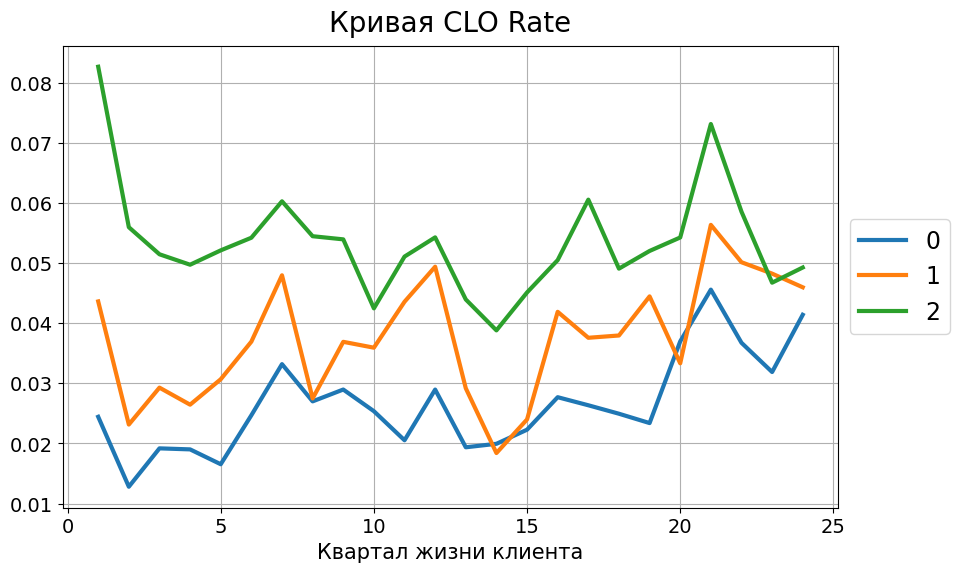

In [ ]:
plot_clo_rate_by_bucket(df, 'x_bucket')
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая CLO Rate", size=20, verticalalignment='bottom')
plt.xlabel("Квартал жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

Видно, что в данном случае лучше себя проявляет уже разбивка по x_bucket: банально у 1 и 2 когорт при разбивке по pd_bucket есть сразу несколько "слипающихся" участков кривой, что конечно очень плохо для разделения.

### Анализ поколений (0.5 баллов)

Отрисуй распределение данных во времени в разбивке по выбранной перменной

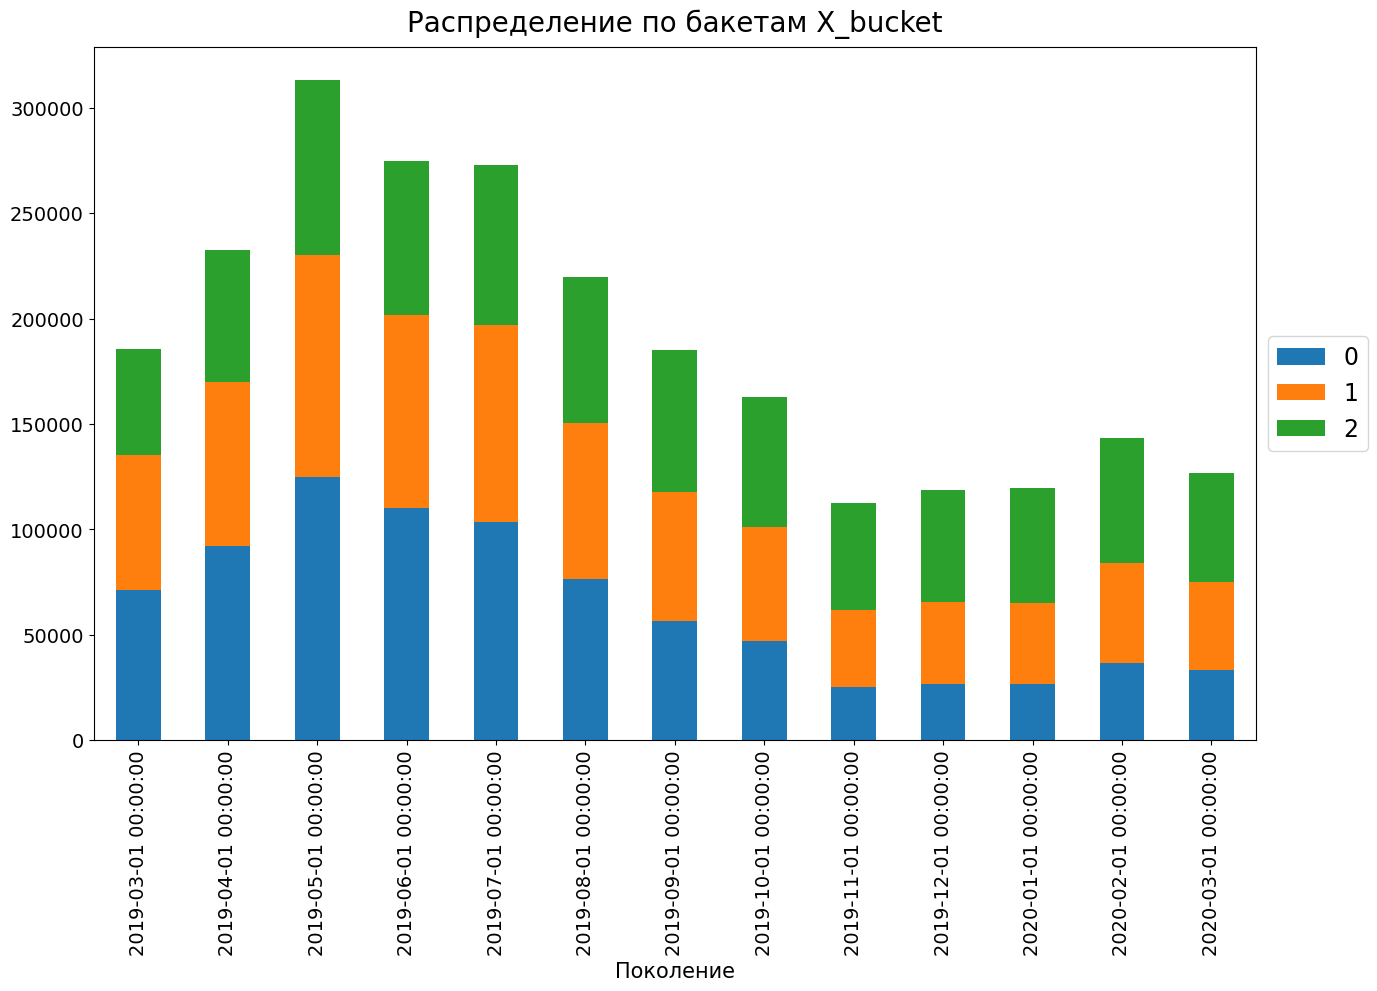

In [ ]:
def plot_distribution(df, bucket):
    return pd.pivot_table(df, index=[bucket], columns='gen_month_dt',          # делаем сводную таблицу и транспонируем ее
                values="user_id",
                aggfunc=np.count_nonzero, fill_value=0)\
               .T\
               .plot(kind='bar', stacked=True, figsize=(15, 9))                    # Рисуем график распределения столбиками

plot_distribution(df, 'x_bucket')

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Распределение по бакетам X_bucket", size=20, verticalalignment='bottom')
plt.xlabel("Поколение", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

Сейчас особо выделяющихся по численности/соотношению бакетов поколений нет, следовательно можно ничего не выбрасывать

### Кривые DEF Rate в разбивке по бакетам (0.5 баллов)

Реализуй функцию, которая отрисовывает винтажи DEF rate в разбивке по бакетам

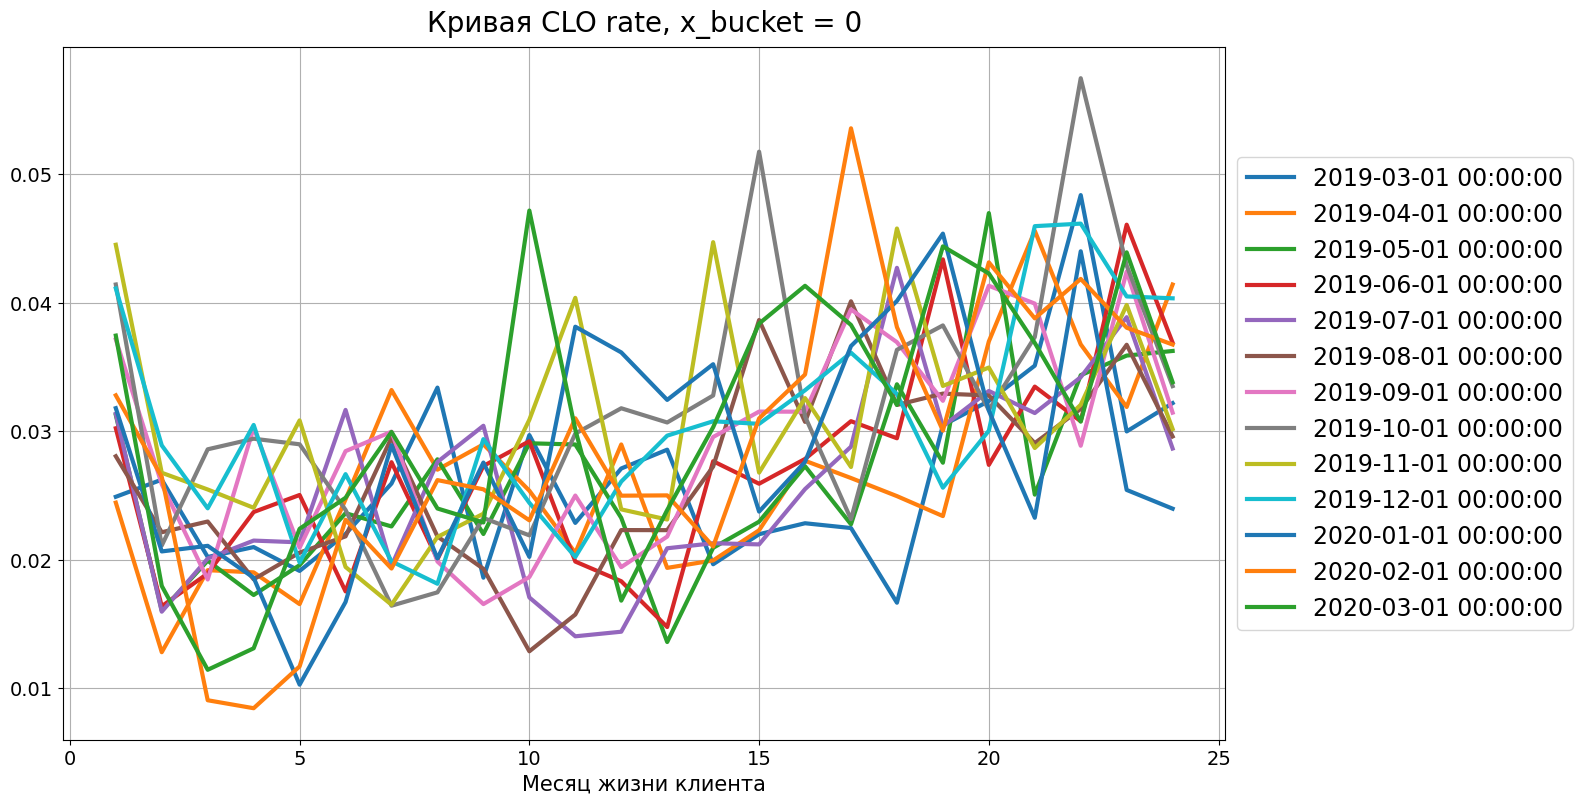

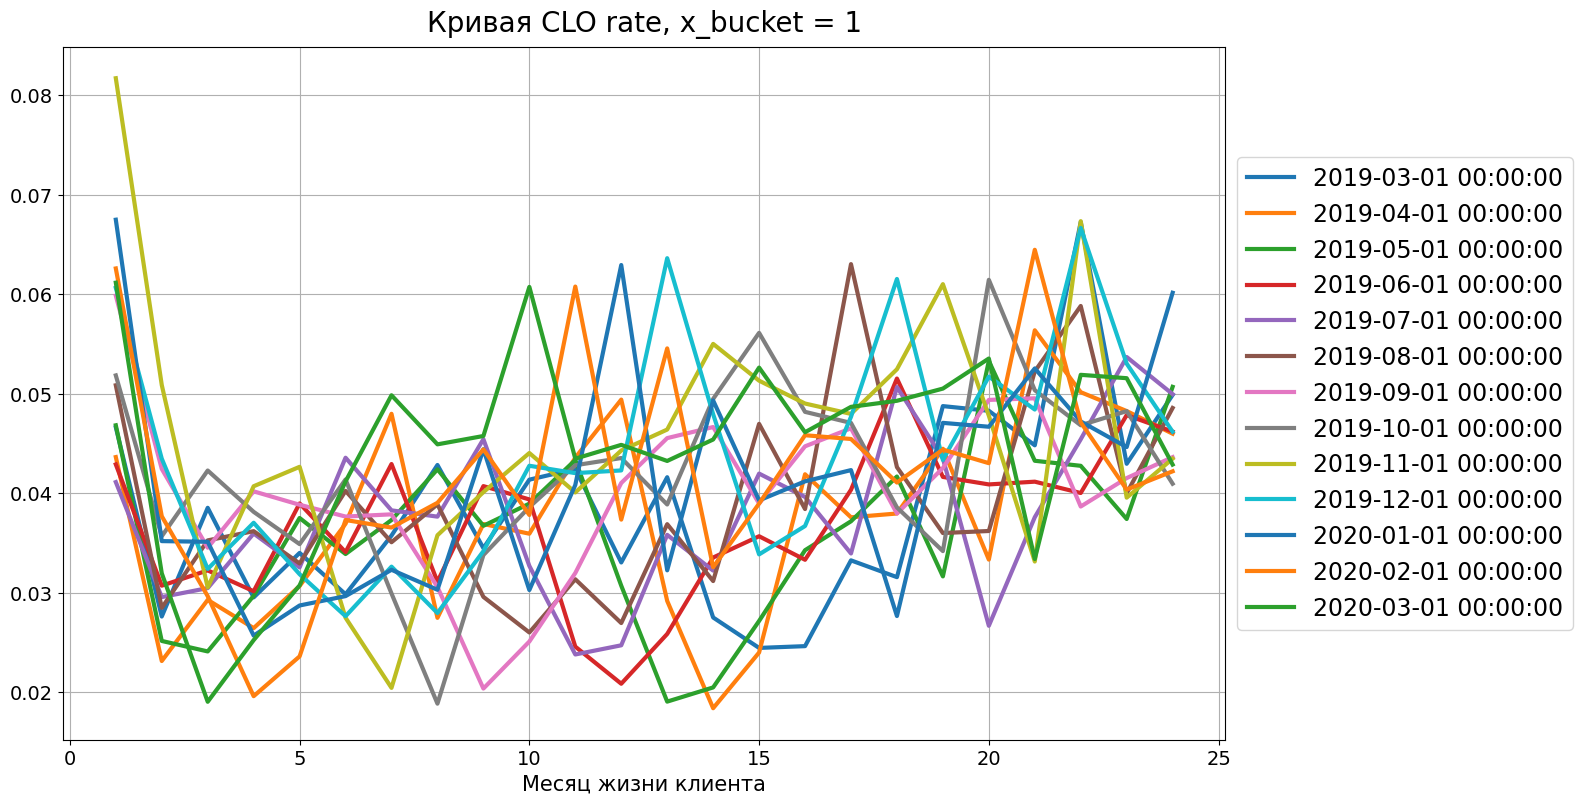

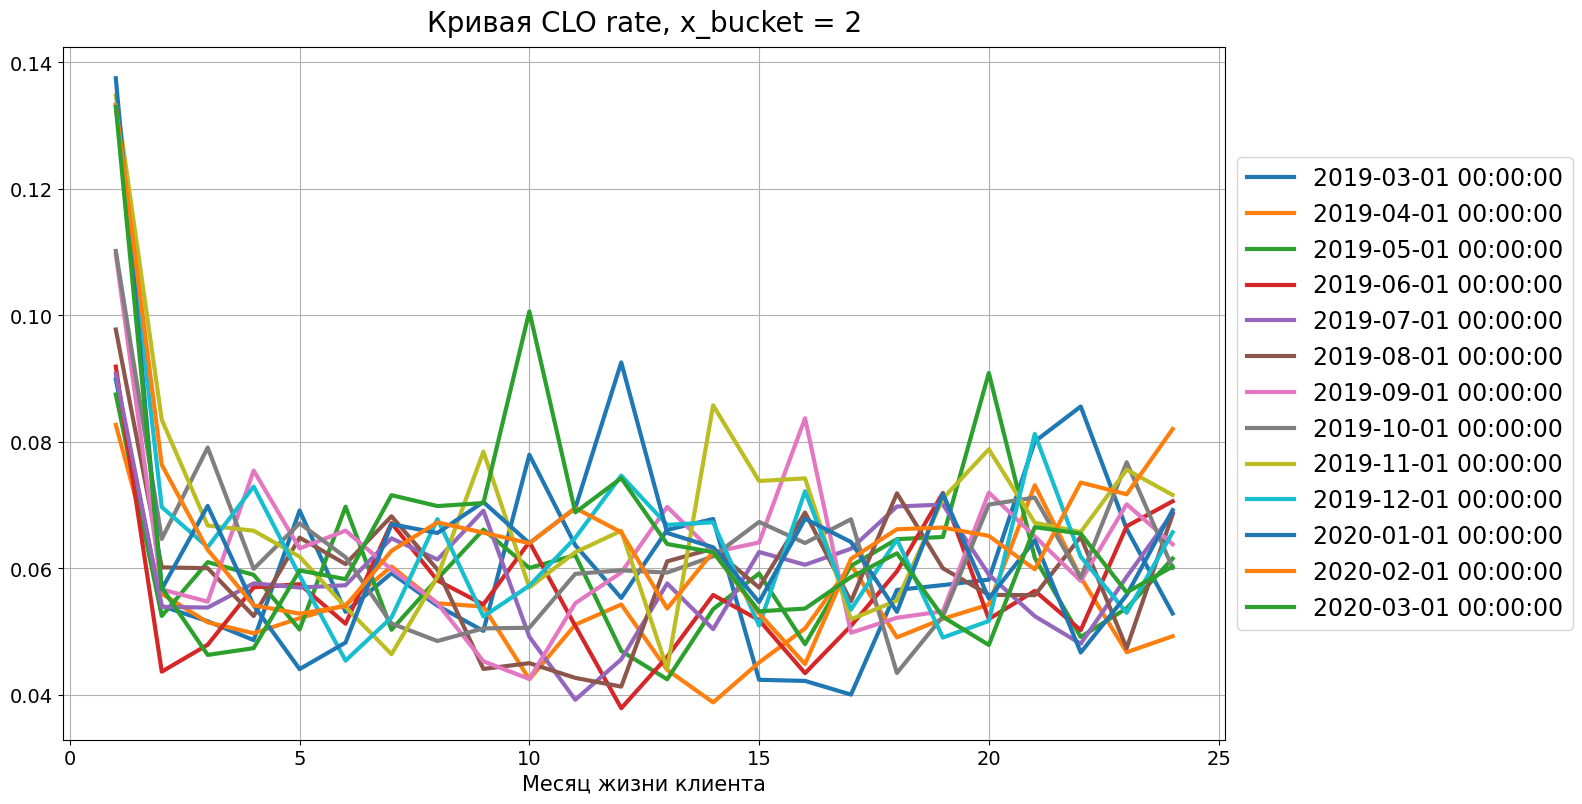

In [ ]:
# Делаем список бакетов
buckets = df['x_bucket'].drop_duplicates().sort_values(ascending = True)


# Строим график, который зависит от бакета

def plot_clo_rate_by_generation(data, bucket):

    df_ = df.query(''' x_bucket == @bucket''').groupby(["gen_month_dt", "statement_num"])\
                    .agg({"clo_flg":np.sum, "clo_flg":np.sum, "prev_clo_flg": np.sum, "prev_act_flg": np.sum}) \
                    .rename(columns = {'clo_flg': 'clo_cnt', 'act_flg': 'act_cnt', 'prev_clo_flg': 'prev_clo_cnt', "prev_act_flg": "prev_act_cnt"}) \
                    .eval("clo_rate = (clo_cnt - prev_clo_cnt) / prev_act_cnt").unstack('gen_month_dt')

    df_['clo_rate'].plot(ax=None, figsize=(15, 9), grid=True, lw = 3)

    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
    plt.title("Кривая CLO rate, x_bucket = " + str(bucket), size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)


for i in buckets:
    plot_clo_rate_by_generation(df, i)


### Особые точки (0.5 баллов)
#### Есть ли в винтажах особые точки? Укажи их. Какова их природа? Нужно ли их исключать?

Видно что есть прям большое количество скачков, которые находятся близко по датам для всех бакетов; здесь явно прослеживается определенное внешнее воздействие

### Макроэкономические воздействие (2 балла)

#### Есть ли в винтажах DEF rate макроэкономическое воздействие (нарисуй график иллюстрирующее это воздействие)? Если да, то предположи какое событие его вызвало и почему?
#### В случае наличия внешнего влияния
#### 1) Разложи кривые на внешнее воздействие и созревание кривых
#### 2) Отрисуй график внешнего воздествия
#### 3) Отрисуй вычищенные винтажи def rate в разбивке по бакетам
#### 4) Посчитай среднее для этих бакетов и реализуй сглаживание

In [ ]:
def curve_build(data,
                feature,
                generation = 'generation_quart',
                statement_num = 'statement_num',
                group_label = '1'):

    """Вспомогательная функция для построения разложения в рамках одного бакета

    **Аргументы**
    data : pandas.DataFrame
        таблица с данными
    feature: str
        название поля с исследуемой переменной
    generation : datetime
        название поля с поколениями
    where : str
        условие, которым мы ограничиваем выборку
    statement_num : int
        название поля с номером месяца жизни клиента
    group_label : str
        название поля группы
    **Результат**
    dictionary : dict
    """

    df_query = data.sort_values([generation, statement_num]).reset_index()

    # Рассчитываем количество поколений и тому подобное
    generation_min = df_query[generation].min()
    gen_cnt = df_query[statement_num].max()

    # Преобразуем Dataframe в набор векторов
    values = np.array(df_query[feature])
    tab_size = df_query[feature].count()
    st_nums = np.array(df_query[statement_num] - 1)
    dates = np.array([0 for i in range(tab_size)])

    for i in range(tab_size):
         dates[i] = df_query.loc[i,generation].year * 12 + df_query.loc[i,generation].month -\
            generation_min.year * 12 - generation_min.month + df_query.loc[i,statement_num] - 1

    # Определяем функционал, который будем минимизировать

    def r_square(x):
        temp = 0
        for i in range(tab_size):
            if dates[i] >= 0:
                temp += (values[i] - x[dates[i]] * x[st_nums[i] + gen_cnt])**2
        return temp

    # Задаем callback для отслеживания прогресса минимизации
    def callbackF(Xi):
        global Nfeval
        print('%d  %.6f' % (Nfeval, r_square(Xi)))
        Nfeval += 1

    # Задаем начальное приближение в виде массива с нулевыми значениями

    x0 = np.array([0.001 for i in range(2*gen_cnt)])                                # Внешние воздействия

    # Численная минимизация

    print('Initial %.6f' % (r_square(x0)))
    res0 = minimize(r_square, x0, tol=1e-6, callback=callbackF, method='Powell', options = {'disp': False, 'maxiter': 1000})

    # Задаем датафрейм с внешними воздействиями
    external_data = pd.DataFrame({'month_dt': [generation_min + pd.DateOffset(months = i) for i in range(gen_cnt)],
                             group_label: res0.x[:gen_cnt]})

    # Нормируем внешние воздействия таким образом, чтобы в среднем они равнялись единице.
    ext_mean = external_data[external_data['month_dt'] > generation_min + pd.DateOffset(months = 6)][group_label].mean()
    external_data[group_label] = external_data[group_label] / ext_mean

    # И умножаем на полученный коэффициент кривые созревания

    maturation_array = np.transpose([res0.x[gen_cnt:2* gen_cnt] * ext_mean]).flatten()
    maturation_data = pd.DataFrame(data = {group_label: maturation_array, \
                                           'statement_num': np.arange(1,maturation_array.size + 1)})

    df_fitted = df_query.merge(right=external_data, on = 'month_dt')
    df_fitted['fitted_feature'] = df_fitted[feature] / df_fitted[group_label]

    # Формируем словарь c итоговыми данными
    res = {'res0': res0,
          'external_data': external_data,
          'maturation_data': maturation_data,
          'df_fitted': df_fitted}
    return res


def decomposition(df,
                  generation = 'generation_month',
                  group = 'bucket',
                  statement_num = 'statement_num',
                  feature = 'feature',
                  optimization_query = ''):
    """Винтажи исследуемой переменной по календарному времени

    **Аргументы**
    df : pandas.DataFrame
        таблица с данными
    generation : datetime
        название поля с поколениями
    group : str
        название поля с бакетами
    statement_num : int
        название поля с номером выписки
    feature: str
        название поля с исследуемой переменной
    optimization_query: str
        ограничение выборки для оптимизации
    **Результат**
    dictionary : dict
    """

    # Разбираемся со случаем пустых аргументов

    if optimization_query == '':
        df_query = pd.DataFrame(df)
    else:
        df_query = df.query(optimization_query)

    timedelta = df_query[statement_num].apply(lambda x: pd.DateOffset(months=x-1))
    df_query['month_dt'] = pd.to_datetime(df_query[generation] + timedelta)

      # Формируем список бакетов

    df_query.sort_values(by = [group], inplace = True)
    groups = pd.Series(df_query[group].drop_duplicates())

    # Запускаем цикл по бакетам
    i = 0
    for g in groups:
        df_temp = df_query[df_query[group] == g]
        print(group + ' = ' + str(g))

        # Строим разложение для одного бакета
        res = curve_build(df_temp,
                          feature = feature,
                          generation = generation,
                          statement_num = statement_num,
                          group_label = str(g)
                         )
        df_fitted_temp = pd.DataFrame(res['df_fitted'])
        df_fitted_temp[group] = g

        # Если первый шаг в цикле, то формируем датафреймы из результатов минимизации
        if i == 0:
            external_data = pd.DataFrame(res['external_data'])[['month_dt', str(g)]]
            maturation_data = pd.DataFrame(res['maturation_data'])[[statement_num, str(g)]]
            df_fitted = pd.DataFrame(df_fitted_temp)
        # Если шаг не первый, то дописываем столбцы в результаты
        else:
            external_data = external_data.merge(right = res['external_data'], on = ['month_dt'])
            maturation_data = maturation_data.merge(right = res['maturation_data'], on = [statement_num])
            df_fitted = pd.concat([df_fitted, df_fitted_temp])
        i+=1

    res_multiple = {
                    'external_data': external_data,
                    'maturation_data': maturation_data,
                    'fitted_data': df_fitted
                   }
    return res_multiple

In [ ]:
# Подготавливаем данные
df_rate = df.groupby(["x_bucket", "gen_month_dt", "statement_num"])\
                    .agg({"clo_flg":np.sum, "clo_flg":np.sum, "prev_clo_flg": np.sum, "prev_act_flg": np.sum}) \
                    .rename(columns = {'clo_flg': 'clo_cnt', 'act_flg': 'act_cnt', 'prev_clo_flg': 'prev_clo_cnt', "prev_act_flg": "prev_act_cnt"}) \
                    .eval("clo_rate = (clo_cnt - prev_clo_cnt) / prev_act_cnt").reset_index()

# Счетчик итераций
Nfeval = 0

# Проводим разложение кривых
res = decomposition(df_rate,
                    generation = 'gen_month_dt',
                    group = 'x_bucket',
                    statement_num = 'statement_num',
                    feature = 'clo_rate')

<ipython-input-43-1fc1e102d870>:124: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  df_query['month_dt'] = pd.to_datetime(df_query[generation] + timedelta)


x_bucket = 0
Initial 0.272563
0  0.106618
1  0.106394
2  0.106379
3  0.106374
4  0.106372
5  0.106370
6  0.106370
7  0.106369
8  0.106369
9  0.106369
x_bucket = 1
Initial 0.542670
10  0.179463
11  0.178714
12  0.178619
13  0.178578
14  0.178558
15  0.178547
16  0.178541
17  0.178538
18  0.178536
19  0.178535
20  0.178535
21  0.178535
22  0.178535
x_bucket = 2
Initial 1.262832
23  0.321022
24  0.313791
25  0.312063
26  0.311241
27  0.310815
28  0.310592
29  0.310475
30  0.310414
31  0.310382
32  0.310365
33  0.310356
34  0.310351
35  0.310349
36  0.310348
37  0.310347
38  0.310347
39  0.310347


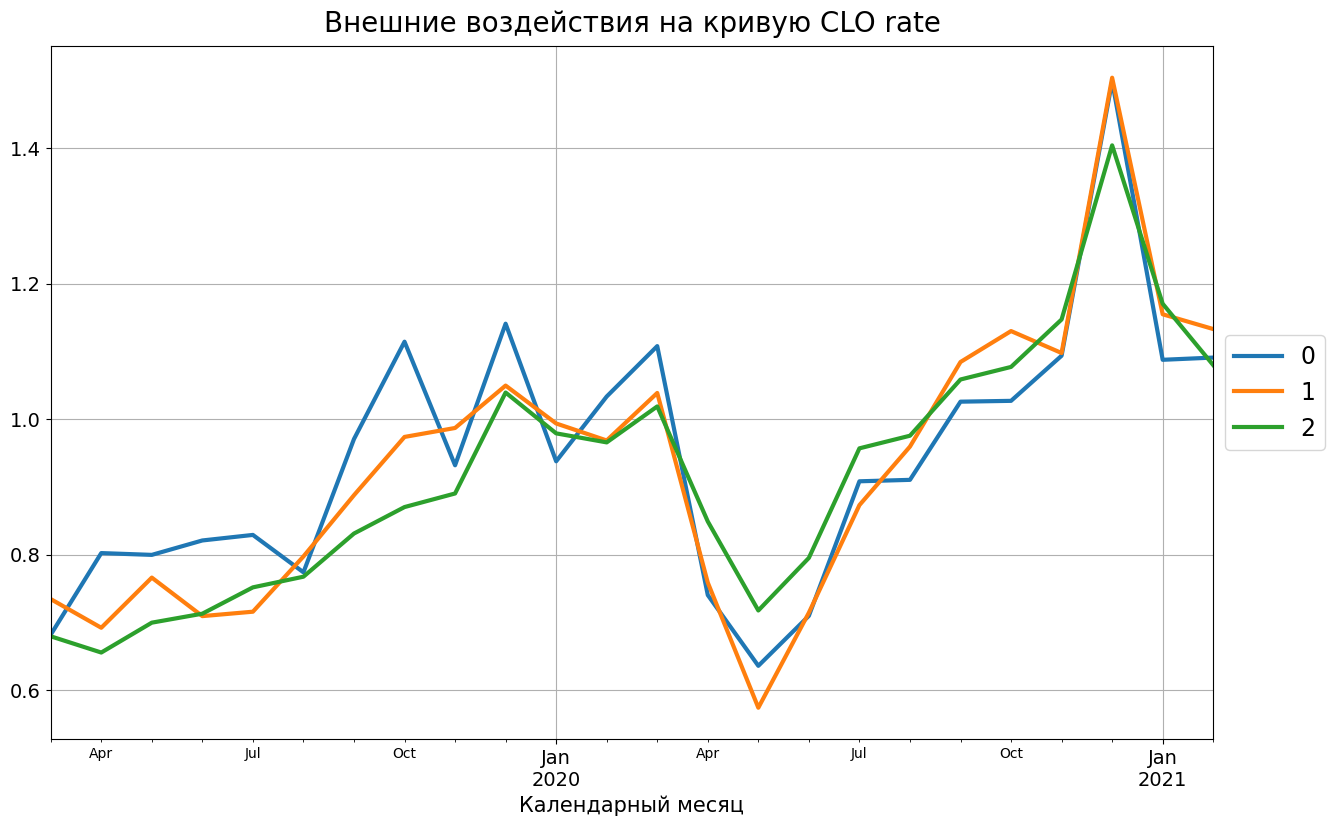

In [ ]:
res['external_data'].set_index('month_dt')\
                    .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Внешние воздействия на кривую CLO rate", size=20, verticalalignment='bottom')
plt.xlabel("Календарный месяц", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

Видим прям несколько ярко выраженных пиков на графике; попробуем дать им некоторое объяснение:

1. Резкий обвал в конце весны 2020 года - очевидные происки ковида
2. Декабрь 2019 и декабрь 2020 годов - кажется, что это лишь желание закрыть кредит перед Новым годом (нечто вроде сезонного квартального пика)
3. Пик в начале 2020 года - скорее всего вызвано снижением ключевой ставки и последовавшим рефинансированием ранее выданных кредитов

Отдельно стоит отметить, что во второй половине 2020 года ставка ЦБ достигла исторического минимума, поэтому на этот период мы видим постоянное повышение clo_rate, которое в конце еще и наложилось на сезонную тенденцию; в результате получился такой большой пик

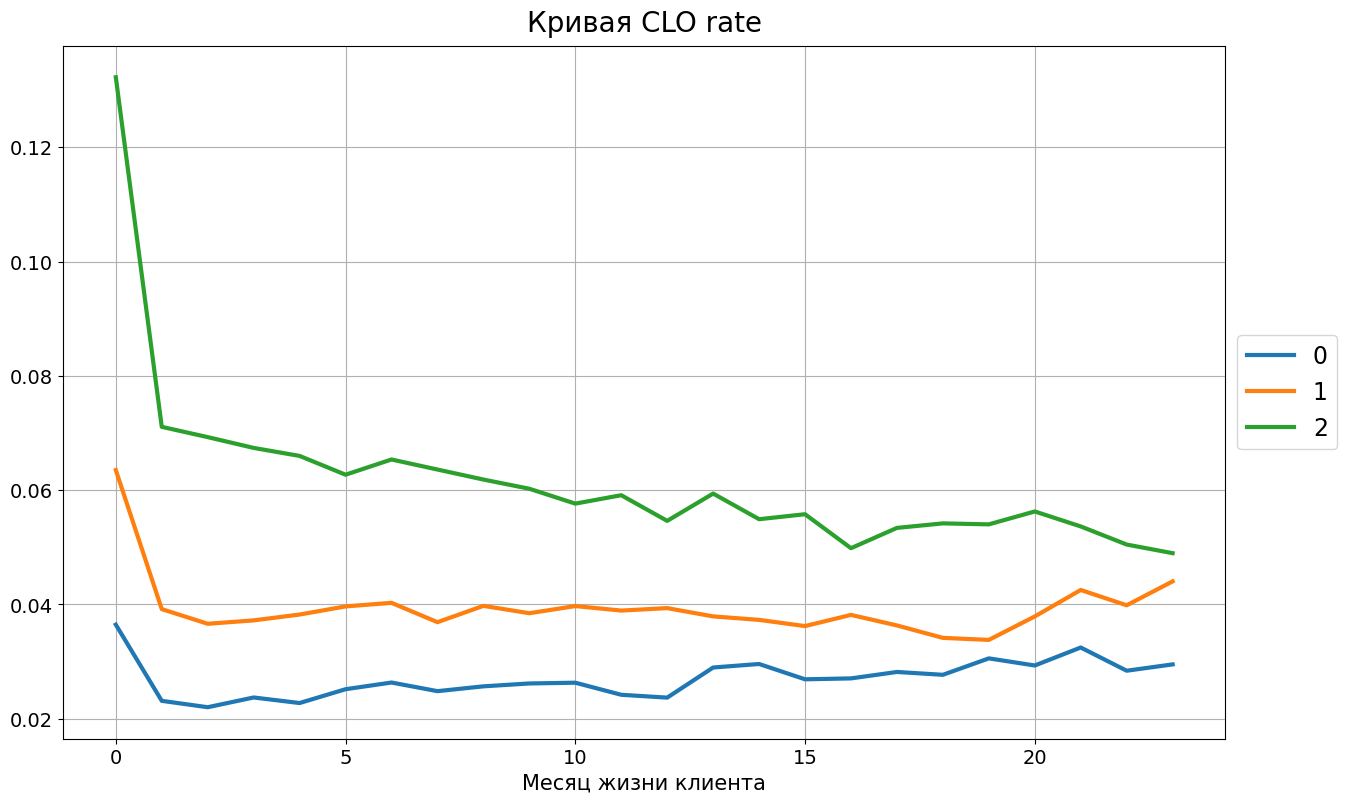

In [ ]:
res['maturation_data'].drop('statement_num', axis=1).plot(ax=None, figsize=(15, 9), grid=True, lw = 3)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая CLO rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

### Среднее по бакетам (0.5 баллов)
Выбери один из способой нахождение средней кривой (возможные способы указаны в лекции). Обоснуй свой выбор.

Реализуй функцию построения среднего.

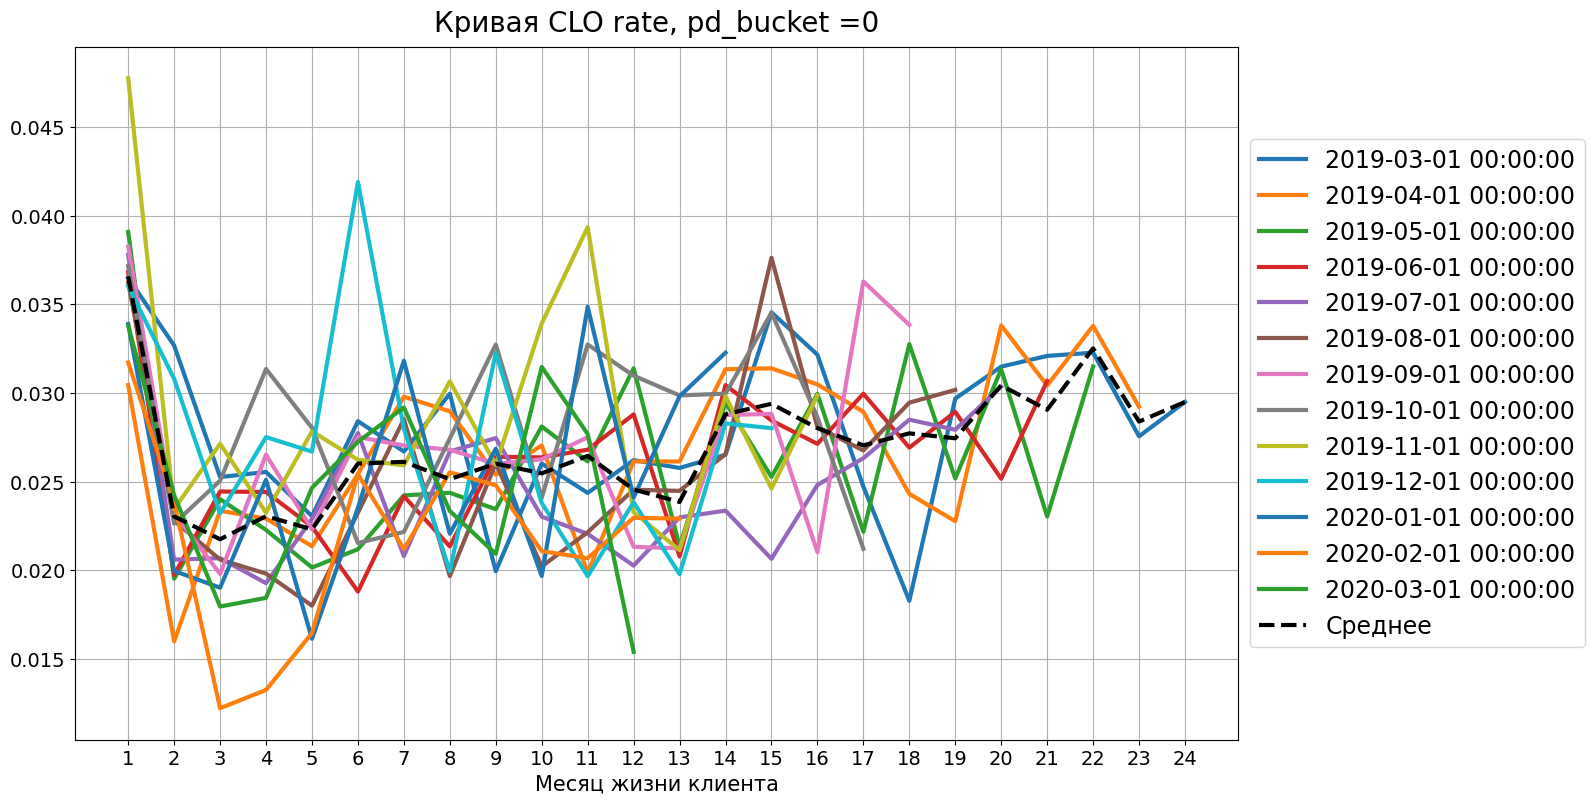

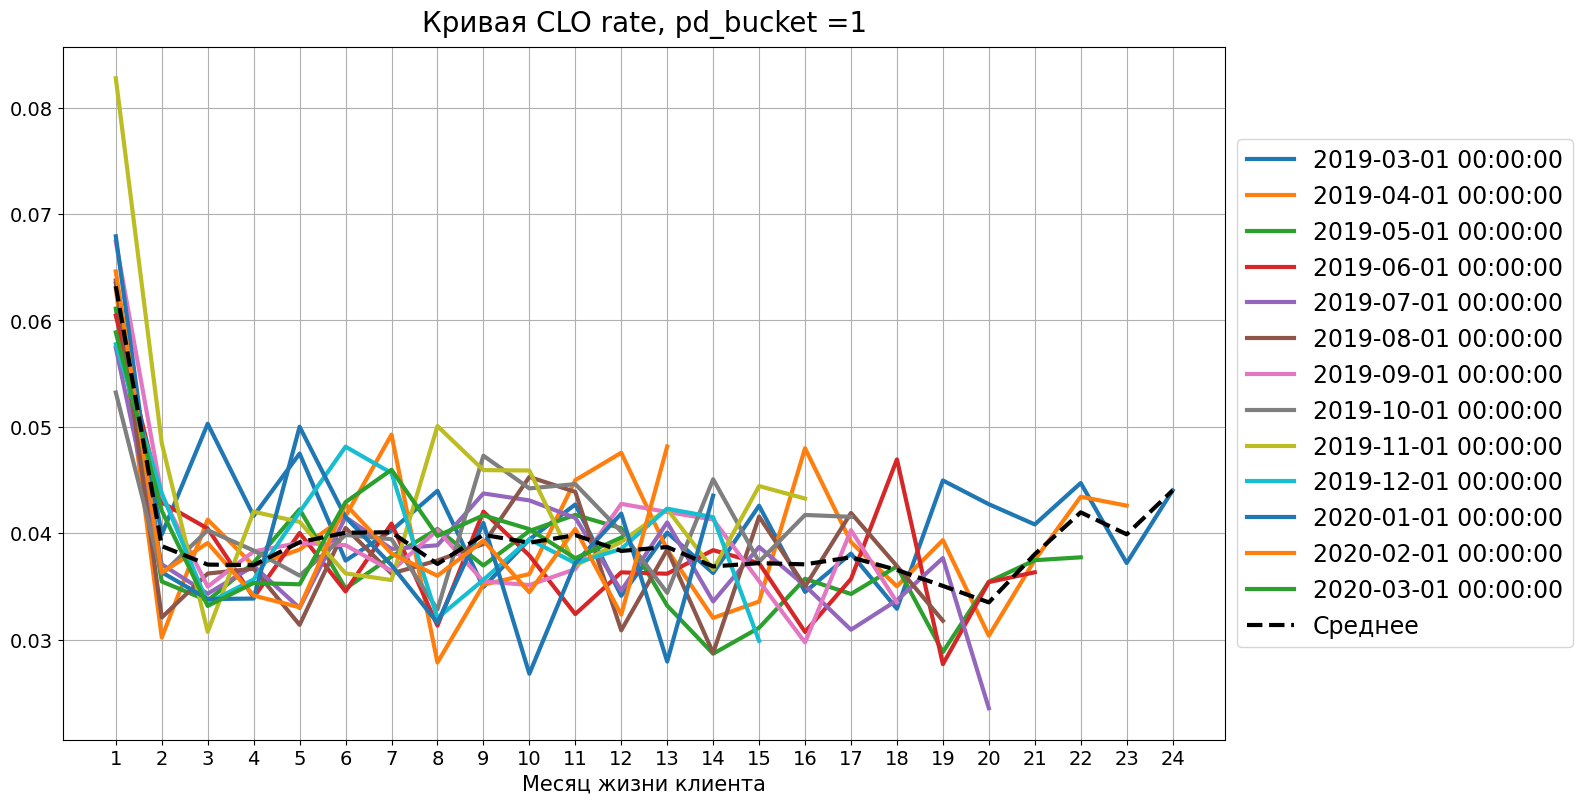

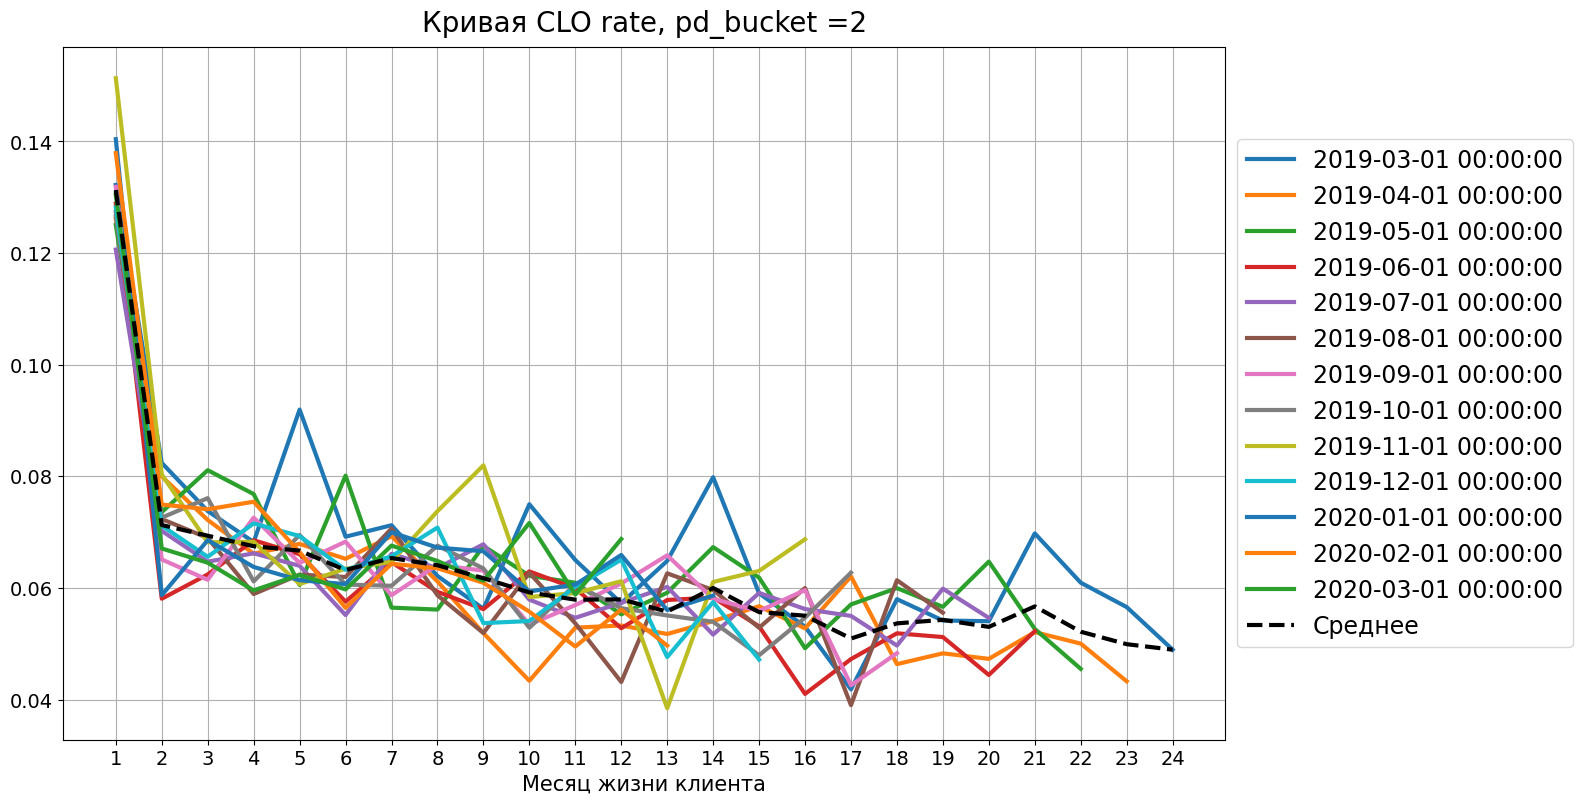

In [ ]:
# Считаем среднее
clo_rate_mean = res['fitted_data'].groupby(['x_bucket', 'statement_num'])\
    .agg({'fitted_feature':np.mean})\
    .rename(columns = {'fitted_feature':'Среднее'})

buckets = df['x_bucket'].drop_duplicates()

# Строим графики винтажей и среднего

def plot_clo_rate_mean(x_bucket):
    res['fitted_data'][0] = 0
    vintages_graph = res['fitted_data'].query('x_bucket == ' + str(x_bucket))\
            .groupby(["gen_month_dt", "statement_num"])\
            .agg({"fitted_feature":np.sum})\
            .unstack('gen_month_dt')\
            ['fitted_feature']\
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3) # график винтажей

    (clo_rate_mean.query('x_bucket == ' + str(x_bucket))['Среднее'][x_bucket]
             .plot( figsize=(15, 9), grid=True, lw = 3, color = 'Black', ls = 'dashed')) # Подаем график винтажей в ось другого, чтобы отобразить их вместе

    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
    plt.title("Кривая CLO rate, pd_bucket =" + str(x_bucket), size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.xticks(np.arange(1, 25))

for i in sorted(buckets):
    plot_clo_rate_mean(i)

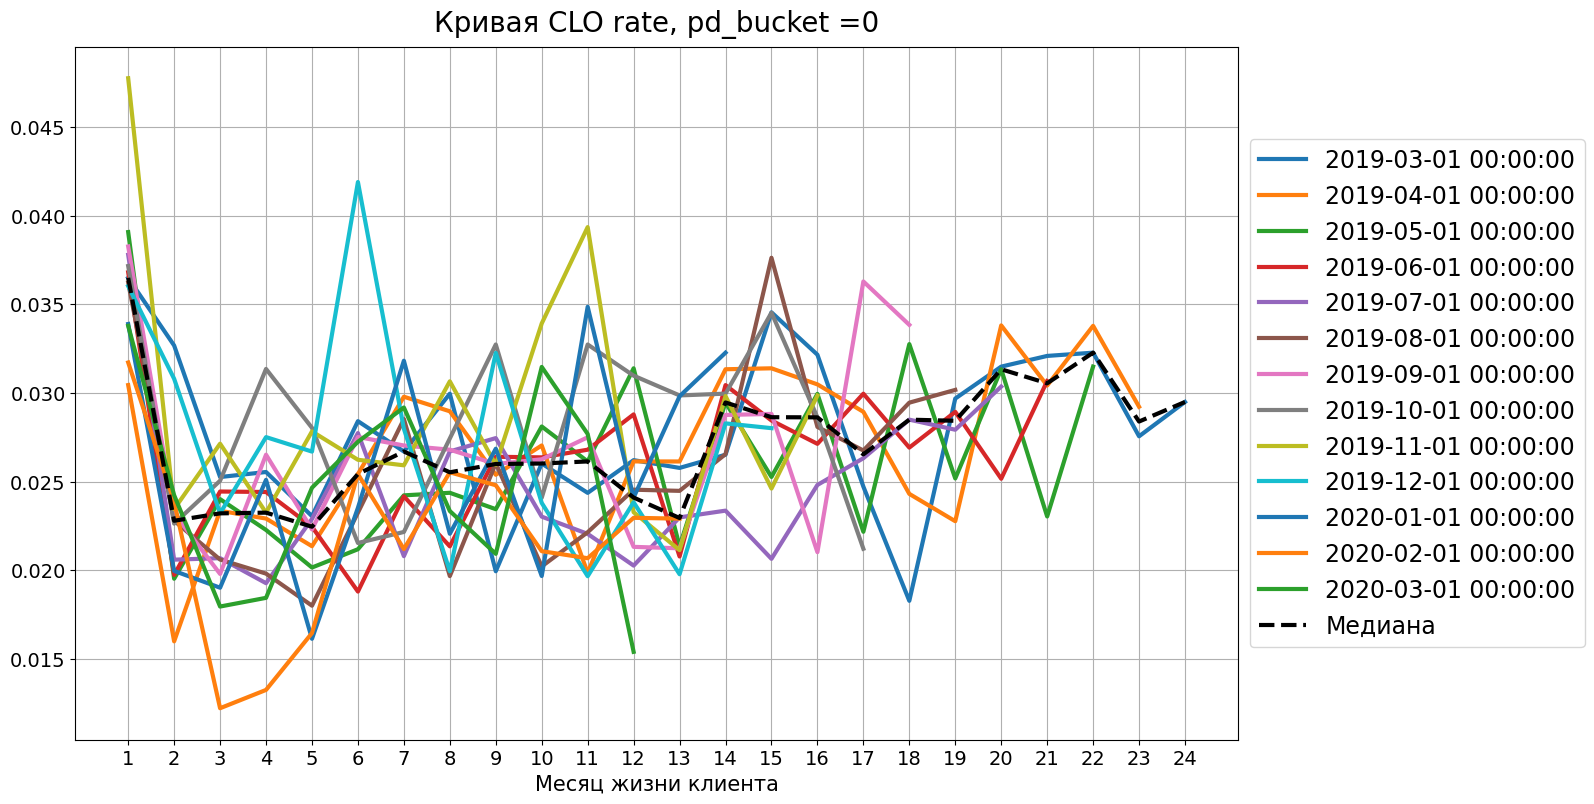

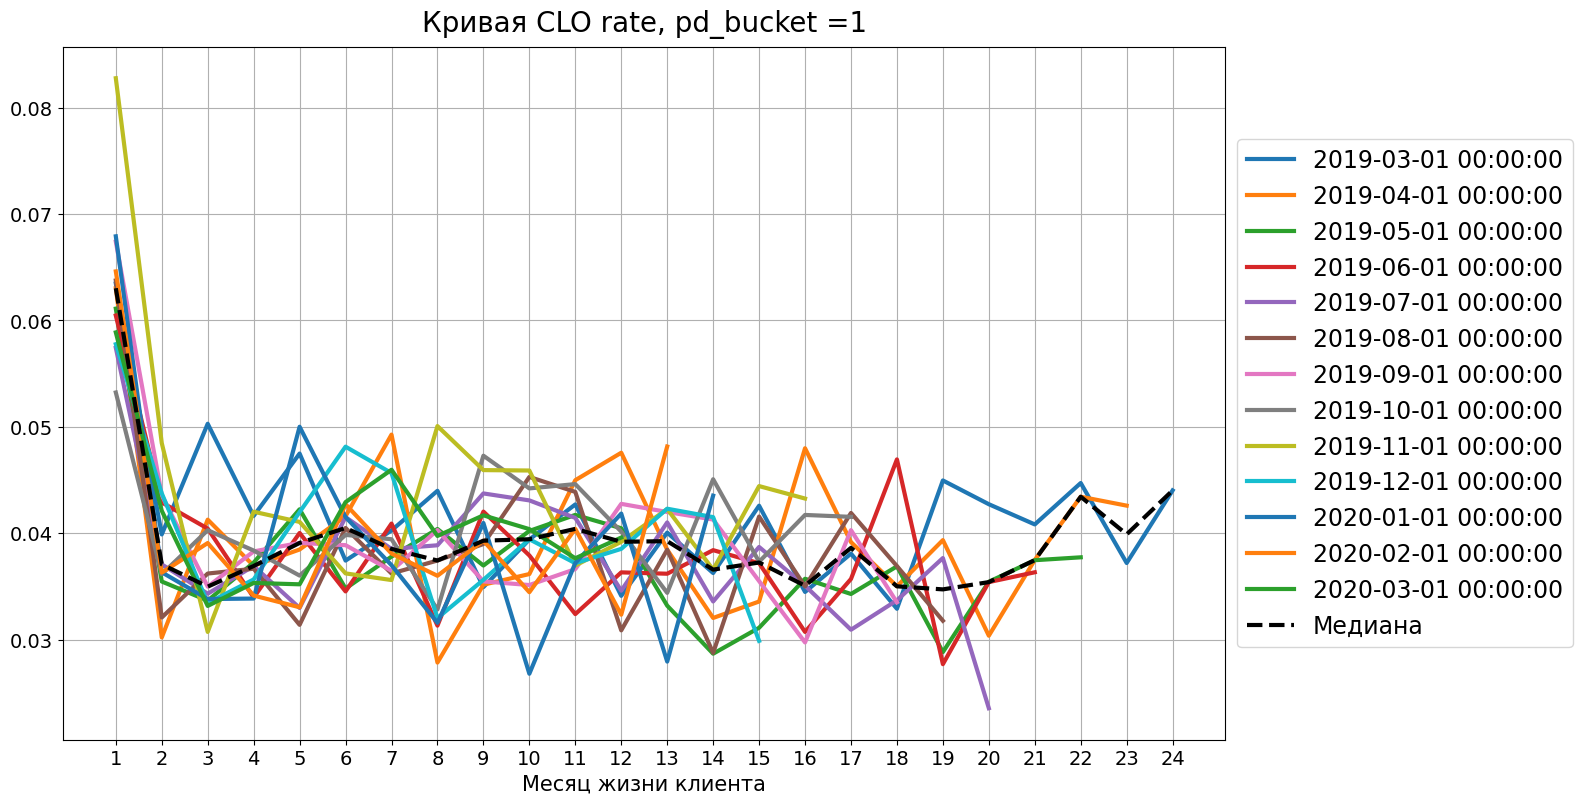

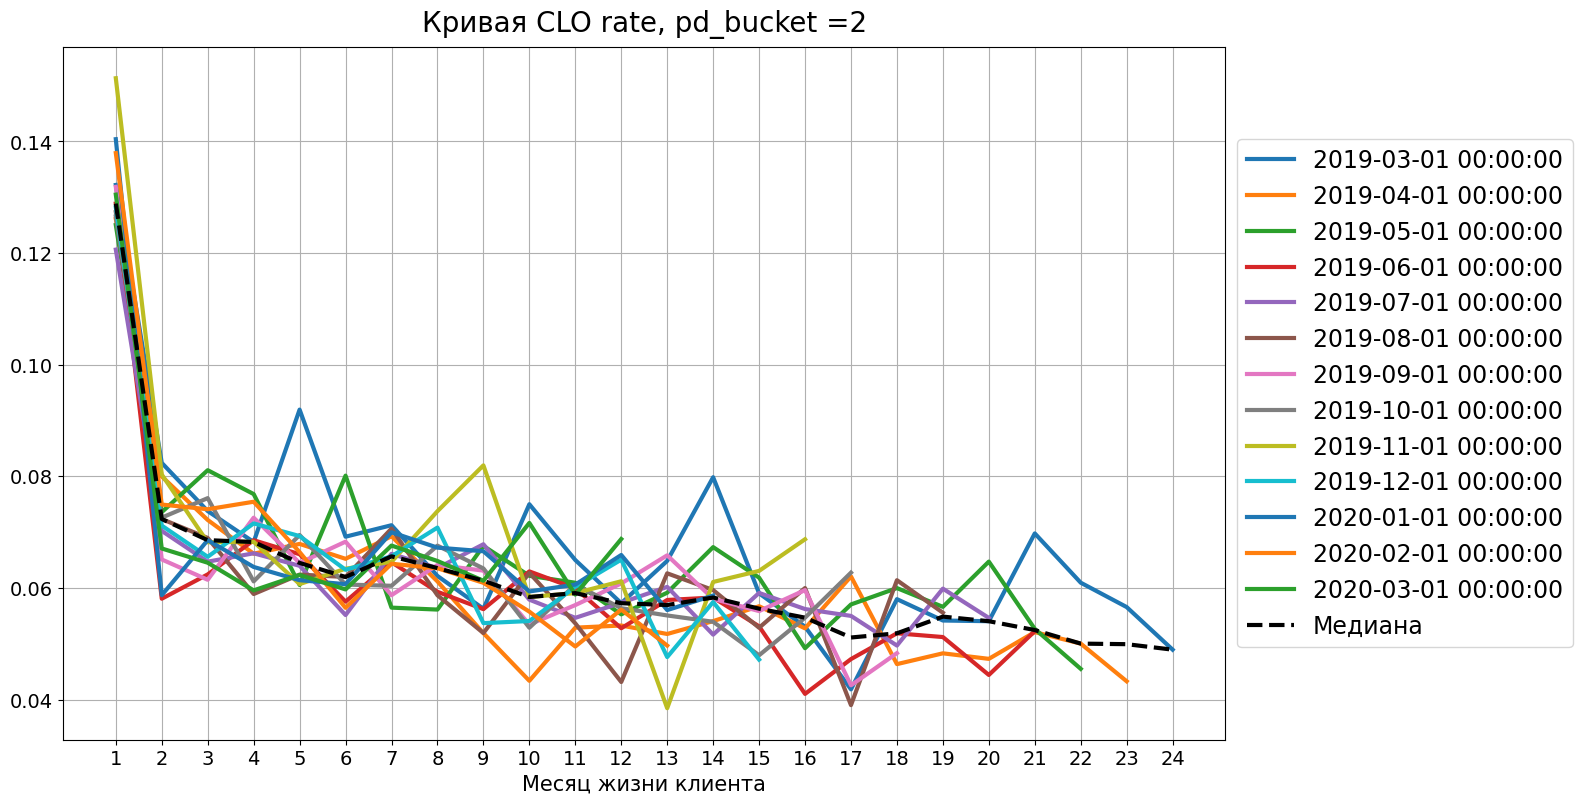

In [ ]:
# Считаем среднее
clo_rate_median = res['fitted_data'].groupby(['x_bucket', 'statement_num'])\
    .agg({'fitted_feature':np.median})\
    .rename(columns = {'fitted_feature':'Медиана'})

buckets = df['x_bucket'].drop_duplicates()

# Строим графики винтажей и среднего

def plot_clo_rate_mean(x_bucket):
    res['fitted_data'][0] = 0
    vintages_graph = res['fitted_data'].query('x_bucket == ' + str(x_bucket))\
            .groupby(["gen_month_dt", "statement_num"])\
            .agg({"fitted_feature":np.sum})\
            .unstack('gen_month_dt')\
            ['fitted_feature']\
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3) # график винтажей

    (clo_rate_median.query('x_bucket == ' + str(x_bucket))['Медиана'][x_bucket]
             .plot( figsize=(15, 9), grid=True, lw = 3, color = 'Black', ls = 'dashed')) # Подаем график винтажей в ось другого, чтобы отобразить их вместе

    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
    plt.title("Кривая CLO rate, pd_bucket =" + str(x_bucket), size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.xticks(np.arange(1, 25))

for i in sorted(buckets):
    plot_clo_rate_mean(i)

Снова не прослеживается прямо существенных отличий между мелианой и средним; поэтому, чтобы немного сильнее учитывать влияние более поздних поколений (да и просто чтобы не усложнять себе жизнь, выдумывая лишнего) возьмем среднее

### Сглаживание средних кривых (0.5 баллов)

Рассмотри несколько функций для сглаживания кривой (можешь взять готовые из семинара, либо реализовать свои).

In [ ]:
def linear_approximation(df, start=1, finish=24):
    df_res = pd.DataFrame(df)
    df_res['Линейная функция'] = df['Среднее']                                                # Копируем средние значения
    linear_coeff = np.polyfit(np.arange(start, finish+1),df.loc[start:finish, 'Среднее'], 1)  # Коэффициенты уравнения прямой
    linear_coeff = np.poly1d(linear_coeff)                                                    # Превращаем коэффициенты в функцию
    df_res.loc[start:finish, 'Линейная функция'] = linear_coeff(np.arange(start, finish+1))   # Записываем приближение
    df_res.loc[finish+1:, 'Линейная функция'] = linear_coeff(finish+1)                        # Продолжаем кривую константой
    return df_res

def polynom_approximation(df, start=1, finish=20, degree = 1):
    df_res = pd.DataFrame(df)
    df_res['Полином'] = df['Среднее']
    linear_coeff = np.polyfit(np.arange(start, finish+1),df.loc[start:finish, 'Среднее'], degree)  # Здесь произвольная степень
    linear_coeff = np.poly1d(linear_coeff)
    df_res.loc[start:finish, 'Полином'] = linear_coeff(np.arange(start, finish+1))
    df_res.loc[finish+1:, 'Полином'] = linear_coeff(finish+1)
    return df_res

def exponential_smoothing(df, start, finish, alpha):
    df_res = pd.DataFrame(df)
    result = [df_res.loc[i,'Среднее'] for i in np.arange(1, start+1)]                              # Начальные значения копируем
    for n in range(start, len(df_res['Среднее'])):
        result.append(float(alpha * df_res.loc[n + 1, 'Среднее'] + (1 - alpha) * result[n-1]))    # Делаем сглаживание
    df_res['Скользящее среднее'] = result
    return df_res

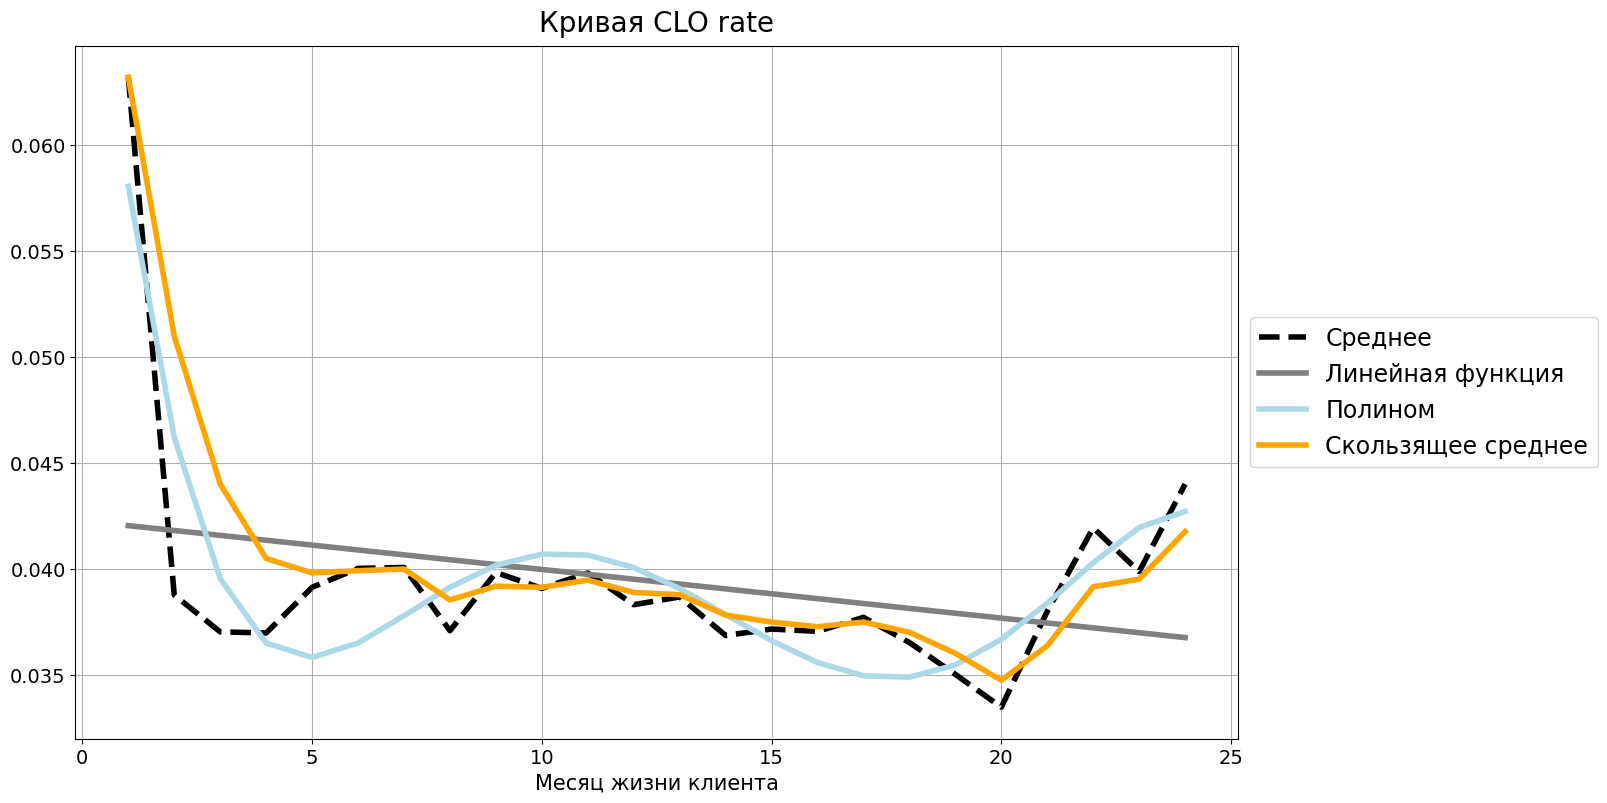

In [ ]:
clo_rate_mean = res['fitted_data'].groupby([ 'x_bucket', 'statement_num'])\
    .agg({'fitted_feature':np.mean})\
    .rename(columns = {'fitted_feature':'Среднее'})

df_linear = clo_rate_mean.query('x_bucket == 1').reset_index().set_index(['statement_num'])
df_linear = linear_approximation(df_linear, 1, 24)
df_polynom = polynom_approximation(df_linear, 1, 24, 5)
df_smooth = exponential_smoothing(df_polynom, 1, 24, 0.5)

# Строим получившиеся графики
plt.figure(figsize=(15, 9))
df_smooth['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
df_smooth['Линейная функция'].plot(grid=True, color = 'Gray', linestyle = '-', lw = 4)
df_smooth['Полином'].plot(grid=True, color = 'LightBlue', linestyle = '-', lw = 4)
df_smooth['Скользящее среднее'].plot(grid=True, color = 'Orange', linestyle = '-', lw = 4)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая CLO rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

#### Вывод: укажи выбранную функцию и обоснуй свой выбор. Были ли точки, к которым не применил сглаживание? Почему?

В данном случае вновь хочется взять полином 5-ой степни, ибо он более-менее улавливает направление в каждой период, при этом не подстраиваясь сильно под данные; линейная функция опять выглядит крайне плачевно, а скользящее среднее плохо улавлиет стремитльный спад в начале и чересчур подстраивается под данные в середине, что не очень хорошо

### Отрисуй сглаженные кривые по всем трем бакетам PD

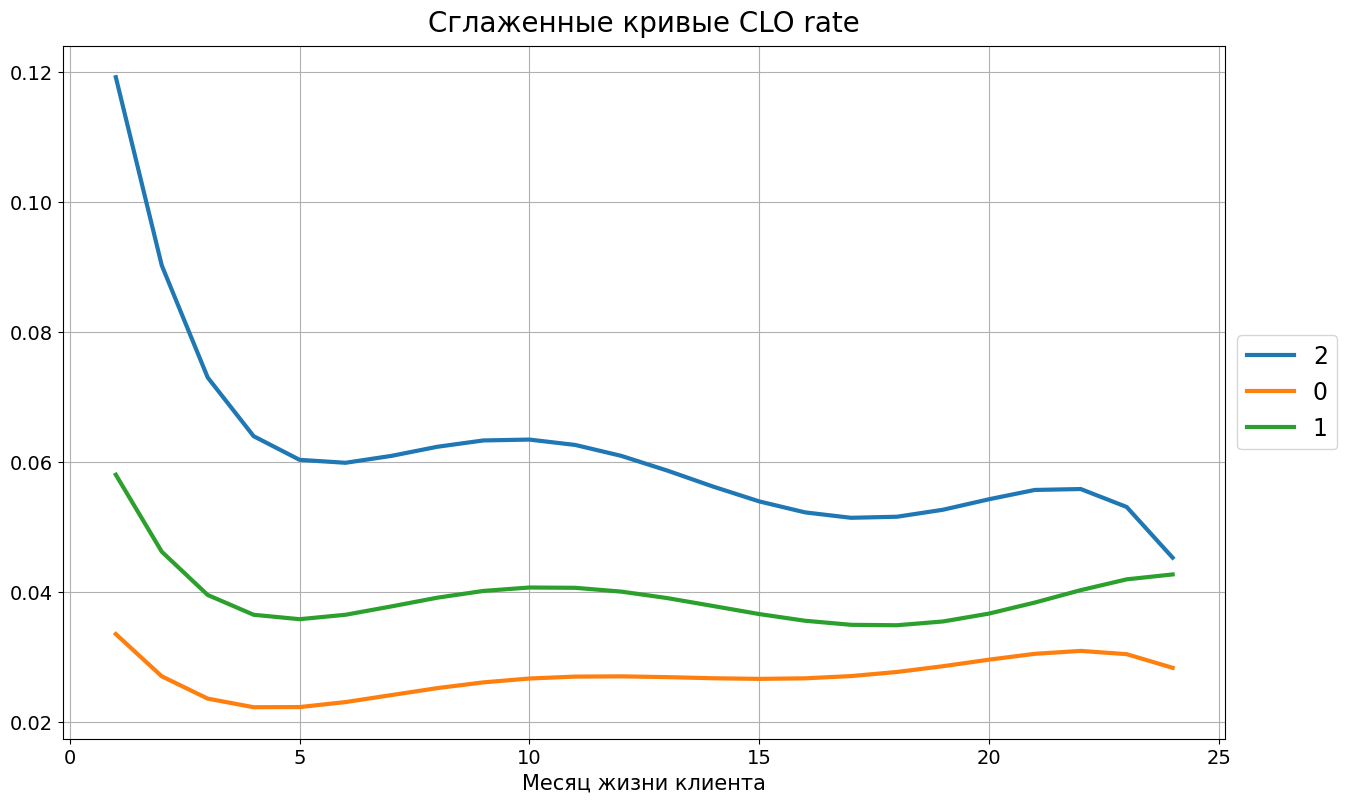

In [ ]:
# Запоминаем набор бакетов и заводим пустой датафрейм под результат

buckets = df['x_bucket'].drop_duplicates()
df_smooth_result = pd.DataFrame()

# Далем полиномиальное сглаживание для каждого бакета
for bucket in buckets:
    df_temp = clo_rate_mean.query('x_bucket == ' + str(bucket)).reset_index().set_index(['statement_num'])
    df_smooth_result[str(bucket)] = polynom_approximation(df_temp, 1, 24, 5)['Полином']

# Строим итоговый график
df_smooth_result.plot(figsize=(15, 9), grid=True, lw = 3)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Сглаженные кривые CLO rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

In [ ]:
df_scores = df_scores.sort_values(['x_score'], ignore_index=True)
df_scores['x_bucket'] = np.minimum(df_scores.index // (df_scores.shape[0]//3),2)
x_buckets = df_scores.groupby(['x_bucket'])['x_score'].mean()

In [ ]:
df_smooth_result.loc[0] = x_buckets.values[[2,0,1]]
df_smooth_result

2         0         1
statement_num                              
1              0.119235  0.033554  0.058068
2              0.090278  0.027050  0.046229
3              0.073031  0.023616  0.039563
4              0.063998  0.022294  0.036520
5              0.060361  0.022316  0.035839
6              0.059907  0.023087  0.036522
7              0.060973  0.024164  0.037810
8              0.062374  0.025238  0.039152
9              0.063345  0.026118  0.040188
10             0.063477  0.026712  0.040716
11             0.062650  0.027005  0.040667
12             0.060972  0.027045  0.040083
13             0.058712  0.026923  0.039089
14             0.056243  0.026752  0.037867
15             0.053971  0.026656  0.036631
16             0.052275  0.026740  0.035600
17             0.051442  0.027085  0.034975
18             0.051605  0.027718  0.034909
19             0.052678  0.028601  0.035488
20             0.054291  0.029609  0.036696
21             0.055729  0.030513  0.038398
22             0.055867  0.030960  0.040310
23             0.053106  0.030459  0.041972
24             0.045309  0.028356  0.042727
0              0.379452  0.133270  0.220838

In [ ]:
df_smooth_result.sort_index().to_csv('clo_rate.csv')